In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import gstools as gs
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patches
import seaborn as sns
import warnings
import os

from utils.case3_vis import *
from utils.MC_case3_nonlinear_forward_3D import *
from utils.DGSA_light import DGSA_light

from inversion_methods.nonlinear_inverse_theta_jointML import *
from inversion_methods.nonlinear_inverse_m_ES import *
from inversion_methods.local_inversion_localPCA import *

plt.rcParams.update({'font.size': 15})
warnings.filterwarnings('ignore')

import pyvista as pv
from pyvista import examples
import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

/mnt/batch/tasks/shared/LS_root/mounts/clusters/pythoninstance4cores/code/Users/hierarchicalBayes/hierarchical_Bayes_v2/utils


Using TensorFlow backend.


In [3]:
path = os.getcwd()
subpath = '/examples/case3_nonlinear_forward_3D/'

In [4]:
fname = '3D_head'
nrow = 200
ncol = 200
nlay = 10

In [5]:
modflowpath = os.getcwd()+'/utils/mfnwt'

# Load and visualize observed data

In [6]:
# observed data
d_obs = np.load(path+subpath+'d_obs.npy')

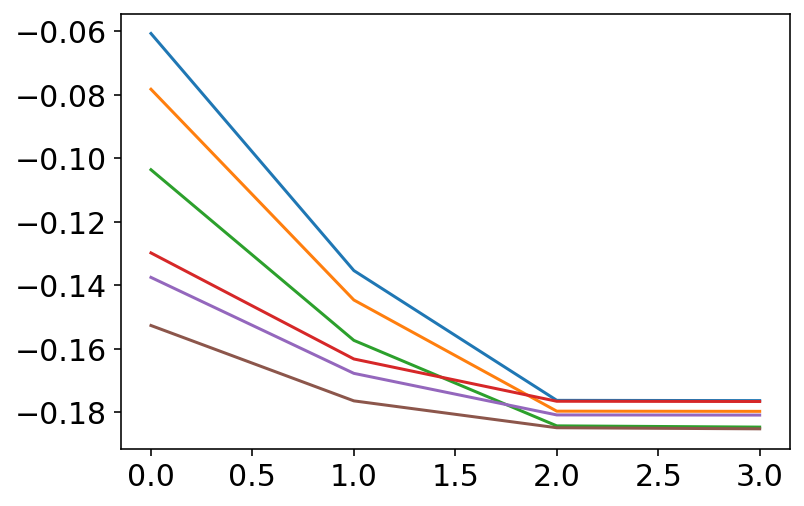

In [8]:
plt.plot(d_obs[:-4].reshape(4,6)) # head data, each line is at one location

## Sneak peek: true model variables

In [9]:
# true global variable, theta_true
theta_name = ['fines_mean', 'fines_var', 'fines_rangeMax_xy', 'fines_rangeMin_xy', 'fines_anisotropy_xy', 
              'gravel_mean', 'gravel_var', 'gravel_rangeMax_xy', 'gravel_rangeMin_xy', 'gravel_anisotropy_xy',
              'fines_vk_ratio','gravel_vk_ratio','ghb_west']
theta_true = np.load(path+subpath+'theta_true.npy')
# true spatial variable, m_true
m_true = np.load(path+subpath+'m_true.npy')

In [10]:
theta_true_df = pd.DataFrame(theta_true,columns = theta_name)

In [11]:
theta_true_df[theta_true_df.columns[:5]]

fines_mean  fines_var  fines_rangeMax_xy  fines_rangeMin_xy  \
0        -3.5        0.2               90.0               50.0   

   fines_anisotropy_xy  
0                 30.0

In [12]:
theta_true_df[theta_true_df.columns[5:10]]

gravel_mean  gravel_var  gravel_rangeMax_xy  gravel_rangeMin_xy  \
0         -1.5         0.4                60.0                60.0   

   gravel_anisotropy_xy  
0                  20.0

In [13]:
theta_true_df[theta_true_df.columns[10:]]

fines_vk_ratio  gravel_vk_ratio  ghb_west
0            -1.5             -1.0       0.1

In [14]:
# well locations
head_wells = np.array([[1,1,1,26,26,26],[75,100,125,75,100,125]])
direct_k_wells = np.array([[26,76],[100,50]])

head_loc = np.zeros((24,3))
ii = 0
for i in range(6):
    for loc in [1,3,5,7]:
        head_loc[ii,:] = np.array([head_wells[0][i],head_wells[1][i],10-loc])
        ii = ii + 1
head_loc = head_loc*[20,20,200]

direct_loc = np.zeros((4,3))
direct_loc[0,:] = np.array([direct_k_wells[0][0],direct_k_wells[1][0],10-1])
direct_loc[1,:] = np.array([direct_k_wells[0][0],direct_k_wells[1][0],10-5])
direct_loc[2,:] = np.array([direct_k_wells[0][1],direct_k_wells[1][1],10-1])
direct_loc[3,:] = np.array([direct_k_wells[0][1],direct_k_wells[1][1],10-5])
direct_loc = direct_loc*[20,20,200]

poly = pv.PolyData(head_loc)
poly["My Labels"] = ['']*24
poly2 = pv.PolyData(direct_loc)
poly2["My Labels"] = ['']*4

ERROR:root:Attempt to use a texture buffer exceeding your hardware's limits. This can happen when trying to color by cell data with a large dataset. Hardware limit is 65536 values while 80000 was requested.


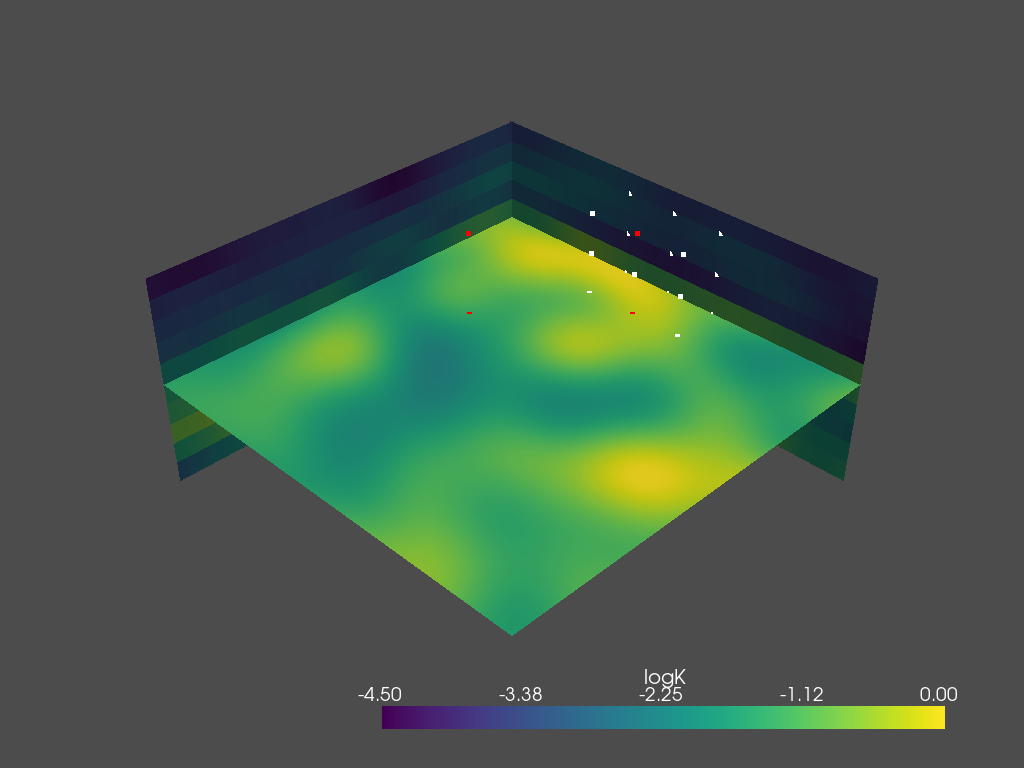

In [15]:
grid = uniform_grid(m_true[0,:,:,:])
p = pv.Plotter()
slices = grid.slice_orthogonal(x=20, y=20, z=1000)
p.add_mesh(slices, cmap='viridis',clim=[-4.5, 0])
p.add_point_labels(poly,"My Labels", point_size=5, font_size=36, shape = 'rounded_rect')
p.add_point_labels(poly2,"My Labels", point_size=5, font_size=36,point_color = 'red',shape = 'rounded_rect')
p.show(jupyter_backend='static')

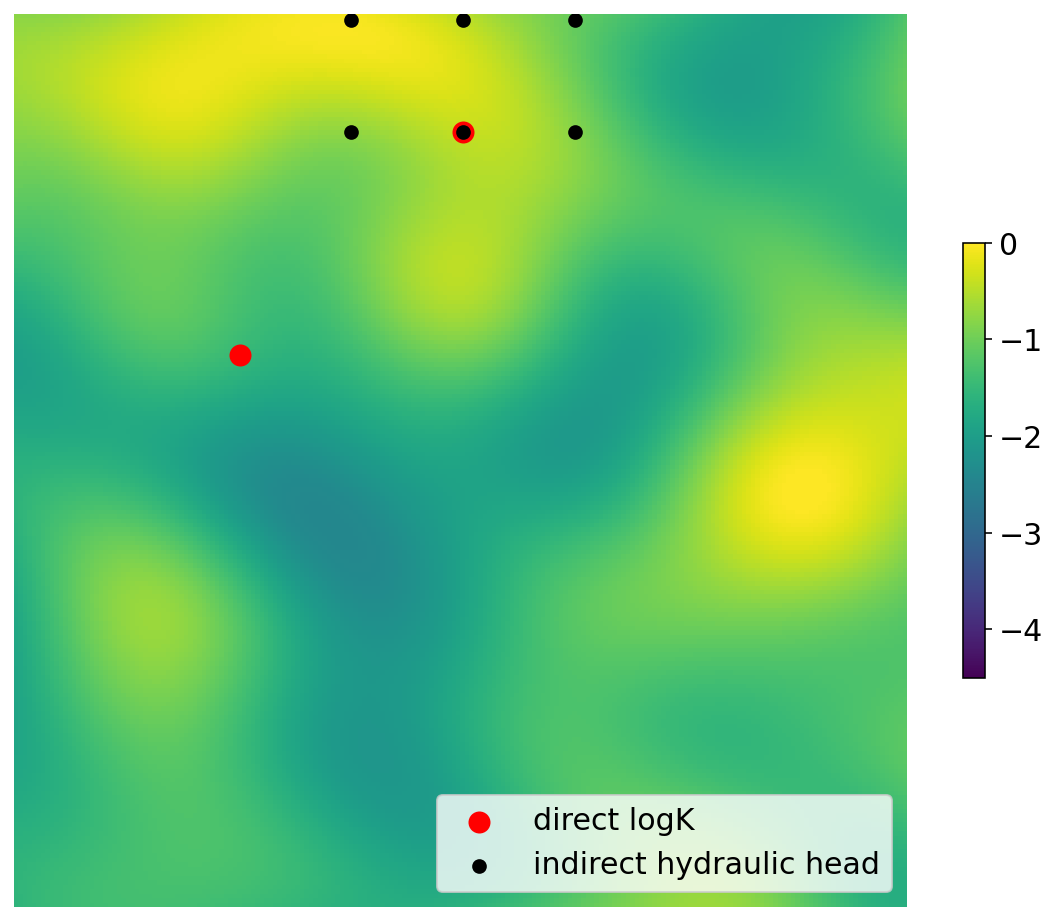

In [16]:
plt.figure(figsize=[10,10])
plt.imshow(m_true[0,:,:,5].T,vmin = -4.5,vmax = 0)
plt.colorbar(shrink = 0.4)

plt.scatter(direct_k_wells[1],direct_k_wells[0],color = 'red',s = 100,label = 'direct logK')
plt.scatter(head_wells[1],head_wells[0],color = 'k',s = 40,label = 'indirect hydraulic head')
plt.axis('off')
plt.legend(loc = 'lower right')

# Monte Carlo sampling: m, theta, d

In [17]:
# MC sampled global variable, theta
theta = np.load(path+subpath+'theta.npy')
# MC sampled spatial variable, m
#m = np.load(path+subpath+'m.npy')
# MC sampled spatial variable, d
d = np.load(path+subpath+'d.npy')

In [18]:
# find the success index modflow
success_index_modflow = np.unique(np.where(~np.isnan(d))[1])

In [19]:
d = d[:,success_index_modflow]
theta = theta[success_index_modflow,:]

In [20]:
# visualize theta
print_theta_multiple(theta,theta_name)

         fines_mean  fines_var  fines_rangeMax_xy  fines_rangeMin_xy  \
theta_1   -3.902373   0.633592          88.691108          64.837750   
theta_2   -3.569621   0.109057          68.565039          77.777098   
theta_3   -3.794473   0.528244          71.389359          86.715056   
theta_4   -3.910234   0.737893          55.031235          91.093468   
theta_5   -4.152690   0.139578          76.302581          88.984763   
theta_6   -3.708212   0.891569          58.174289          49.964625   
theta_7   -4.124826   0.568073          74.637041          89.703373   
theta_8   -3.216454   0.127595          50.180687          43.517744   

         fines_anisotropy_xy  gravel_mean  gravel_var  gravel_rangeMax_xy  \
theta_1            52.675569    -2.266440    0.437314           76.093600   
theta_2           101.973289    -2.404752    0.485817           70.812050   
theta_3            24.734597    -2.862801    0.714751           86.928240   
theta_4            62.948193    -2.294945  

# Sensitivity analysis on global variable

In [21]:
# Sensitivity analysis on d
dgsa_d_theta = DGSA_light(theta, d.T, theta_name,n_clsters=4,n_boots = 3000)
dgsa_d_theta['name'] = theta_name
dgsa_d_theta['sensitive'] = (dgsa_d_theta[0]>1)*1

100%|██████████| 3000/3000 [00:09<00:00, 331.95it/s]


Text(0.5, 1.0, 'Sensitivity analysis')

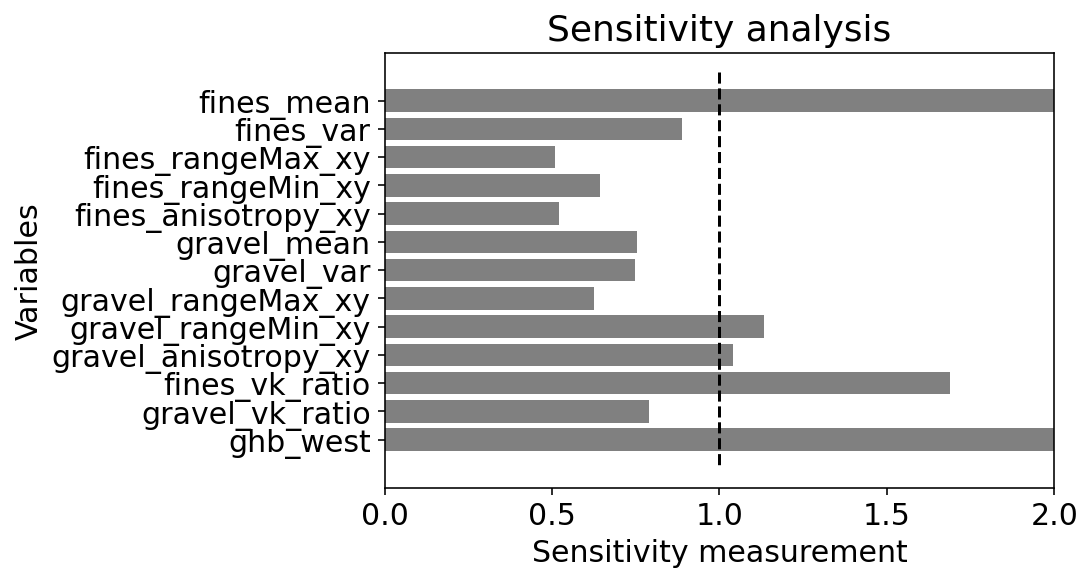

In [22]:
plt.rcParams.update({'font.size': 15})
sns.barplot(x = 0,y = 'name', data=dgsa_d_theta,color = 'grey')
plt.vlines(x = 1, ymin = -1, ymax = len(theta_name),color = 'black',linestyle = '--')
plt.xlabel('Sensitivity measurement')
plt.ylabel('Variables')
plt.xlim(0,2)
plt.title('Sensitivity analysis')

# Hierarchical Bayes: inverse global variable

In [23]:
from sklearn.decomposition import PCA

# PCA on drawdown curve
num_d = d.shape[0]
num_pcs = d.shape[0]
pca = PCA(n_components=num_pcs)
pca.fit(d.T)
d_pcs = pca.transform(d.T)
d_obs_pcs = pca.transform(d_obs.reshape(1,num_d)).T

pc_cutoff = num_d

In [24]:
# Put two anisotropy angles at the end, easier for NN training
theta_shifted = np.hstack([theta[:,[0,1,2,3,5,6,7,8,10,11,12]],theta[:,[4,9]]])
theta_name_shifted = np.copy(theta_name)
theta_name_shifted = [theta_name[i] for i in [0,1,2,3,5,6,7,8,10,11,12,4,9]]
theta_true_shifted = np.array([theta_true[0,i] for i in [0,1,2,3,5,6,7,8,10,11,12,4,9]])

In [25]:
prior_min_theta = np.array([-5., 0.1, 40., 40.,  -3., 0.1, 40., 40.,  -3., -3., -0.25,0.,0.])
prior_max_theta = np.array([-3., 1., 100., 100., -1., 1, 100., 100., 0., 0., 0.25, 180.,180.])

# ML dimension reduction
S_d, S_d_obs,pred_train, y_train, pred_test,y_test,history = ML_dimension_reduction(d_pcs[:,:pc_cutoff], 
                                                                                    d_obs_pcs[:pc_cutoff,:], 
                                                                                    theta_shifted, 
                                                                                    prior_min_theta, 
                                                                                    prior_max_theta,
                                                                                    custom_loss_function_case3,
                                                                                    l1_reg = 2.5e-5,
                                                                                    l2_reg = 2.5e-4,
                                                                                    learning_rate = 1e-3, 
                                                                                    num_input = 28,
                                                                                    num_epoch = 1000,
                                                                                    batch_size = 200)

0epoch [00:00, ?epoch/s]

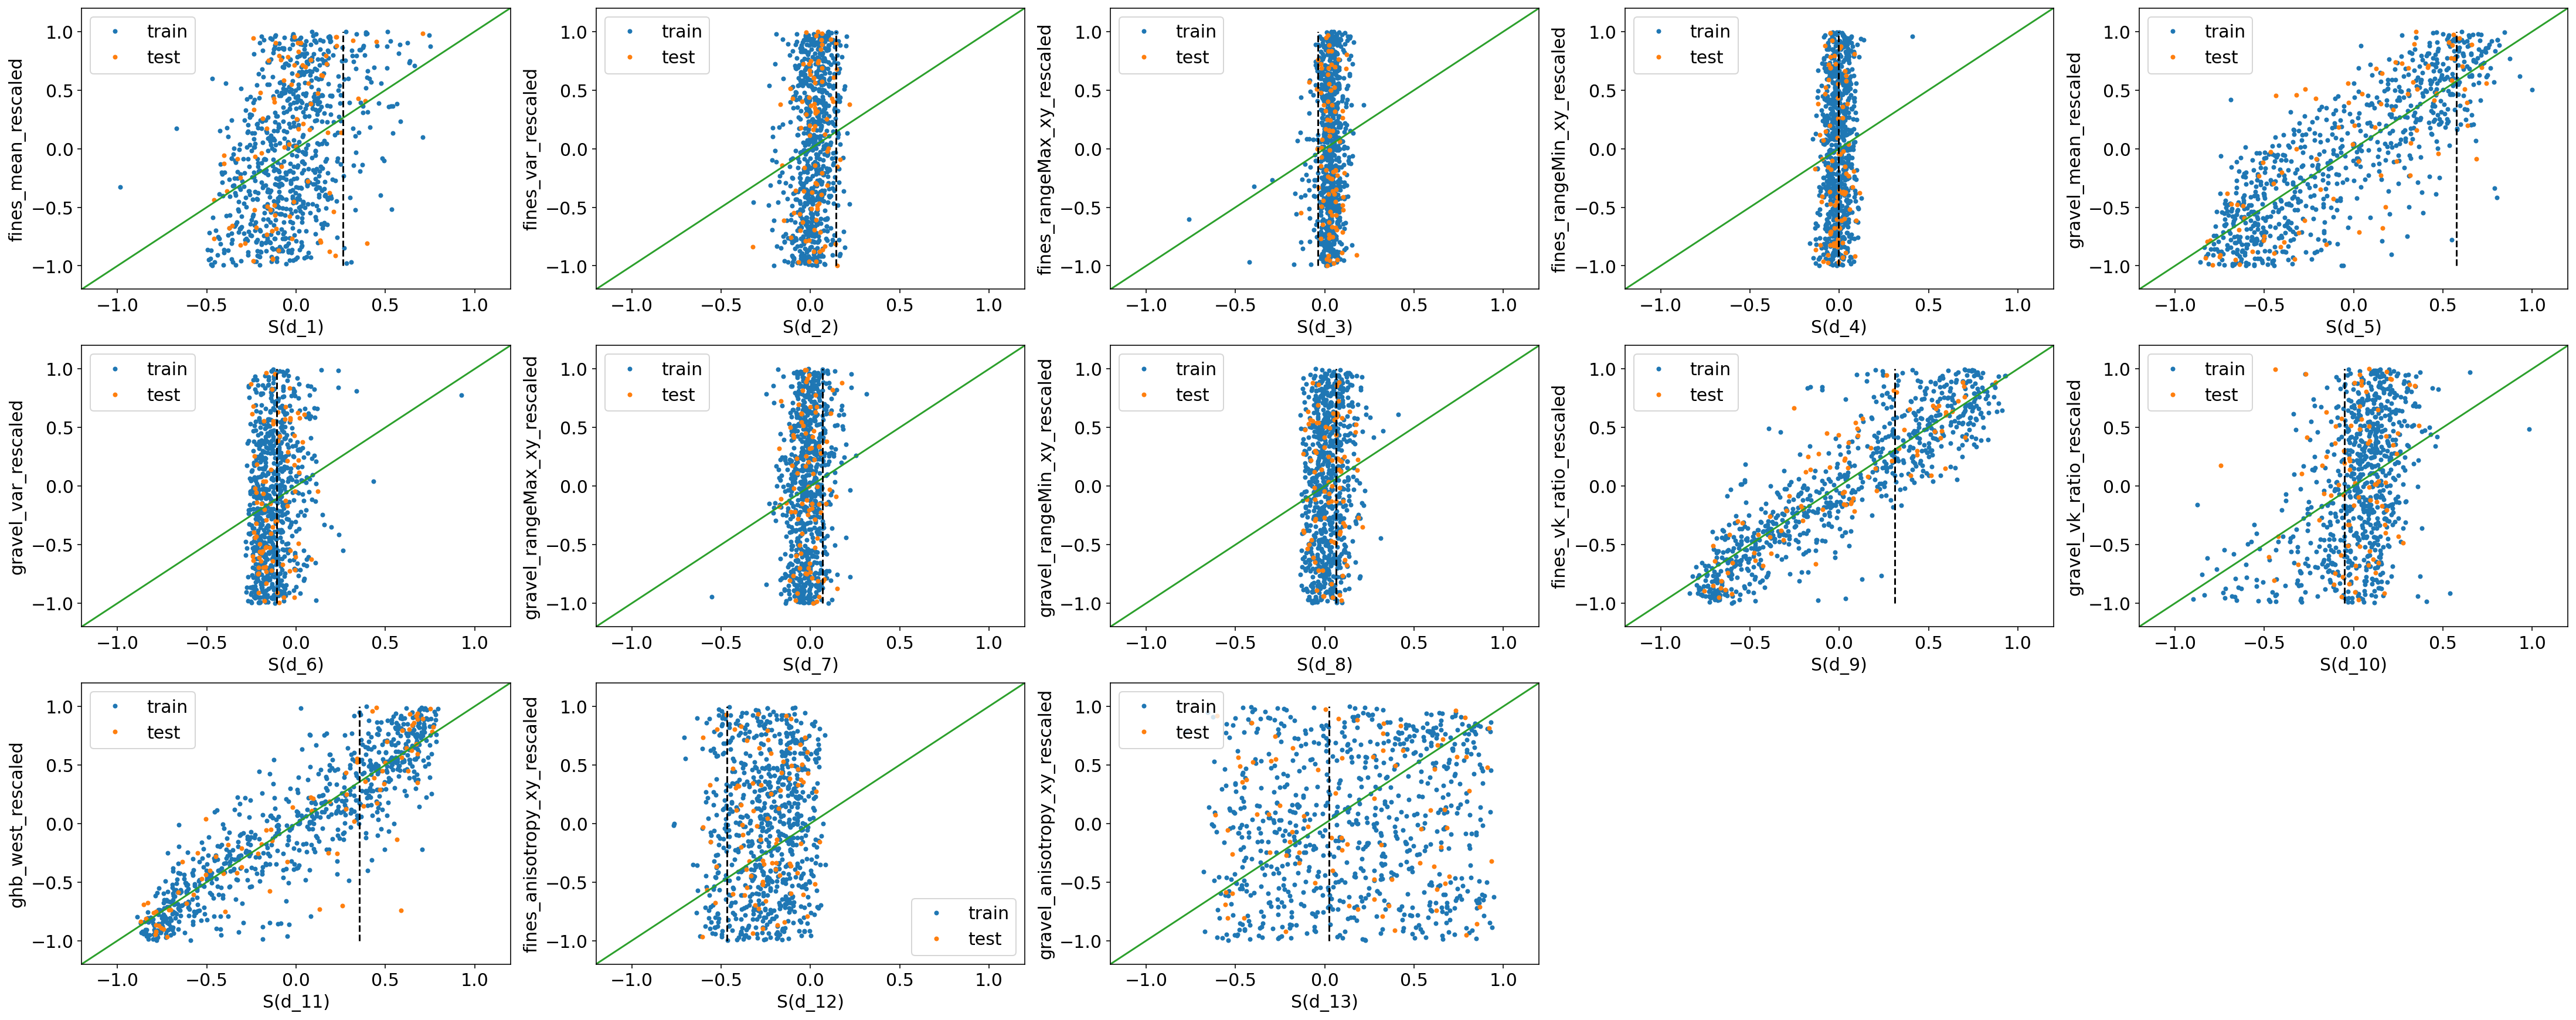

In [26]:
# visualize ML dimenison reduction result
ML_dimension_reduction_vis(pred_train, y_train, pred_test, y_test, S_d_obs, theta_name_shifted)

In [27]:
# posterior sampling from joint distribution
theta_pos_MC = posterior_global_samples_jointML(S_d, S_d_obs, theta_shifted, prior_min_theta, prior_max_theta)

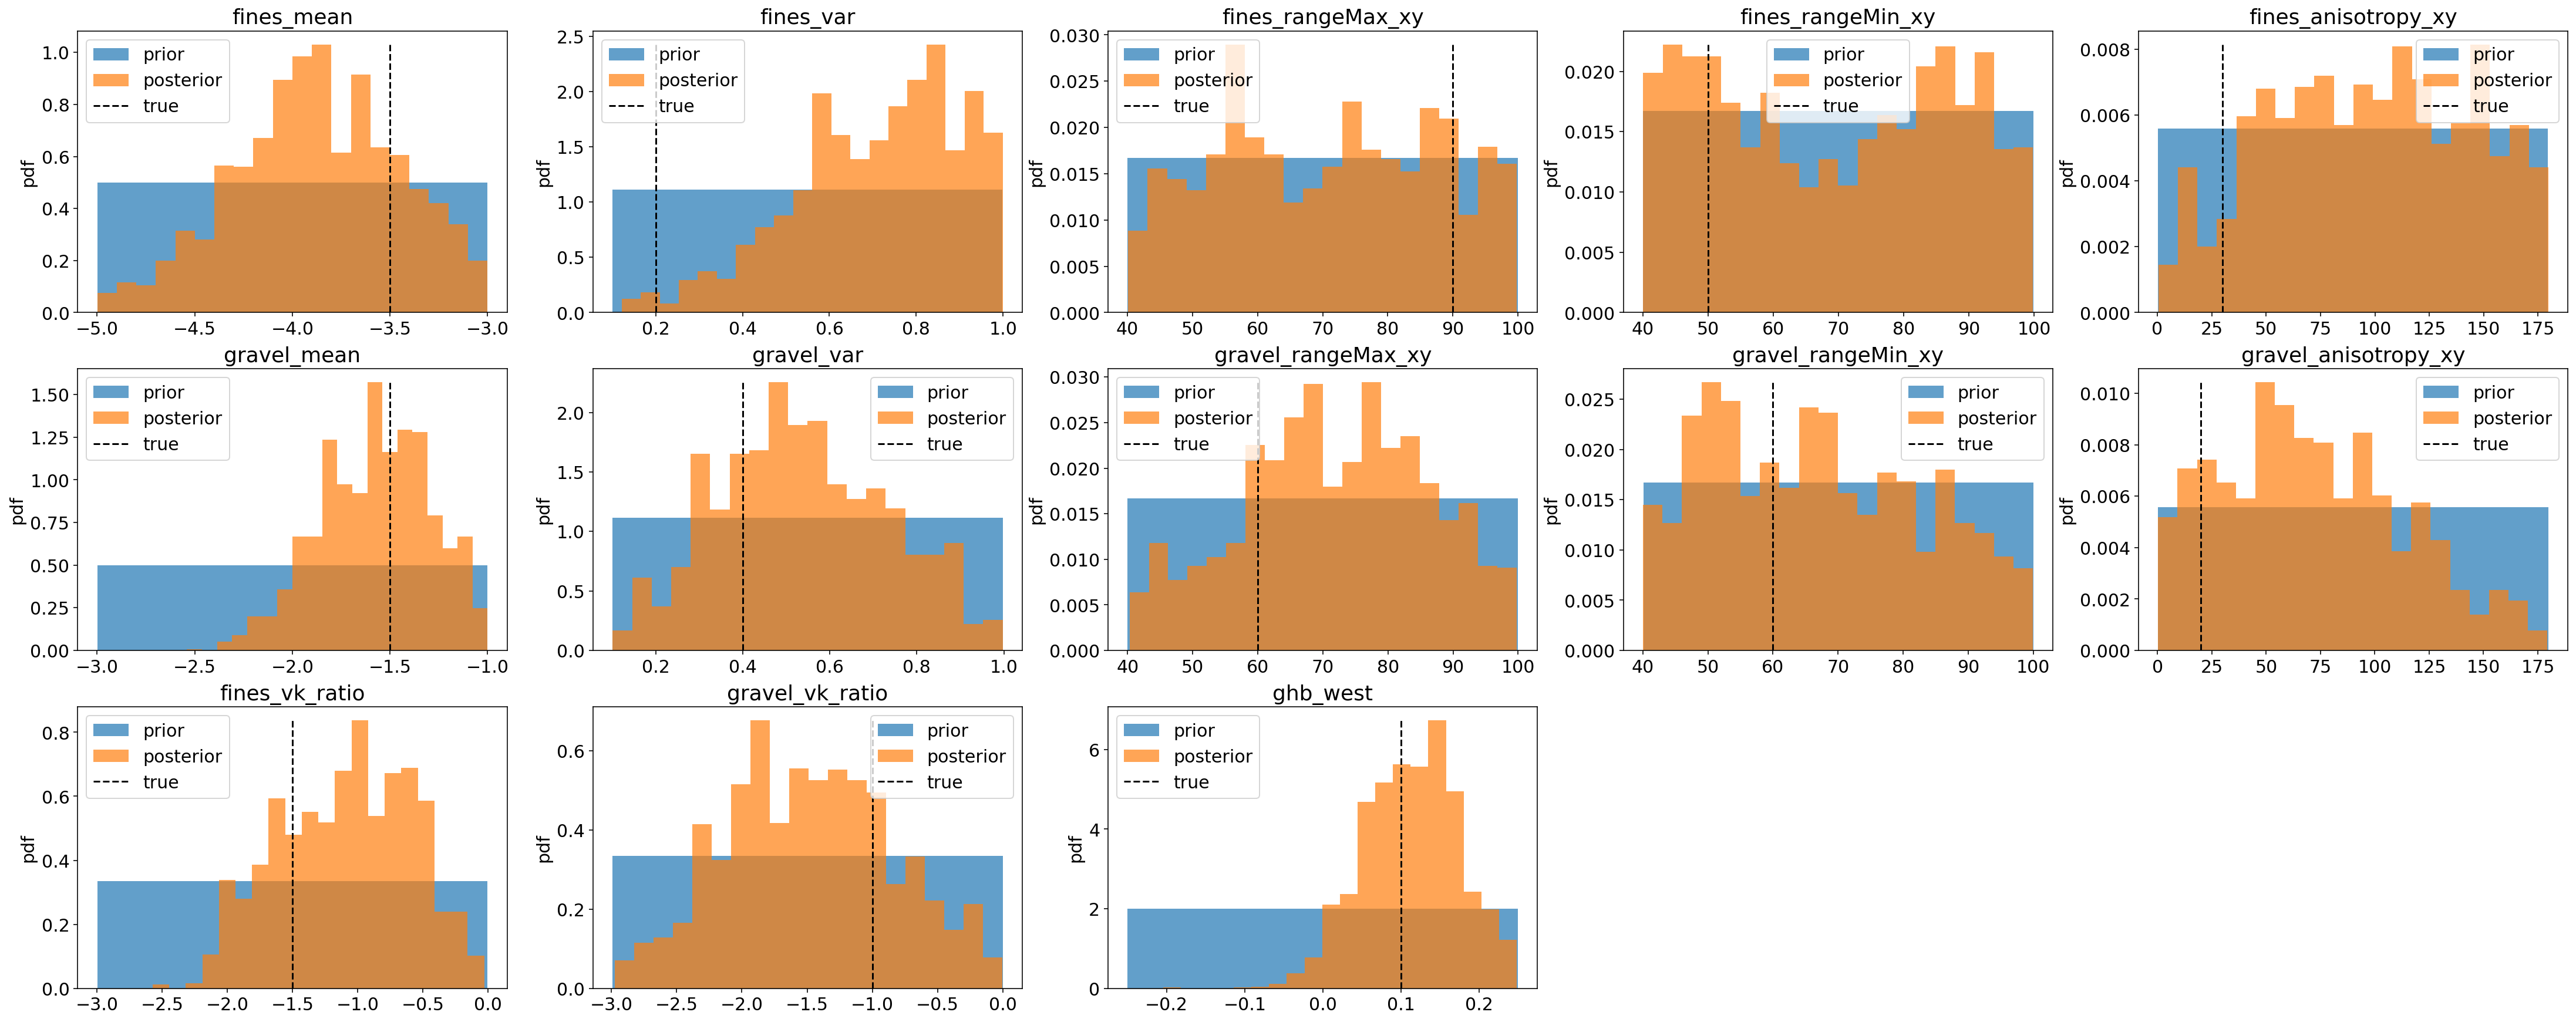

In [28]:
# visualize prior and posterior
prior_pos_theta(theta, theta_pos_MC[[0,1,2,3,11,4,5,6,7,12,8,9,10],:], theta_true[0,:], 
                theta_name)

In [29]:
# You can save your inversion result and reload it
# np.save('saved_inverse_results/posterior_case3.npy',theta_pos_MC)

In [30]:
theta_pos_MC = np.load('saved_inverse_results/posterior_theta_ML_case3.npy')

In [31]:
theta_pos_MC = theta_pos_MC[[0,1,2,3,11,4,5,6,7,12,8,9,10],:]

([<matplotlib.axis.YTick at 0x7f26b86c8240>,
 [Text(0, 0, 'fines_mean'),
  Text(0, 0, 'fines_var'),
  Text(0, 0, 'fines_rangeMax_xy'),
  Text(0, 0, 'fines_rangeMin_xy'),
  Text(0, 0, 'fines_anisotropy_xy'),
  Text(0, 0, 'gravel_mean'),
  Text(0, 0, 'gravel_var'),
  Text(0, 0, 'gravel_rangeMax_xy'),
  Text(0, 0, 'gravel_rangeMin_xy'),
  Text(0, 0, 'gravel_anisotropy_xy'),
  Text(0, 0, 'fines_vk_ratio'),
  Text(0, 0, 'gravel_vk_ratio'),
  Text(0, 0, 'ghb_west')])

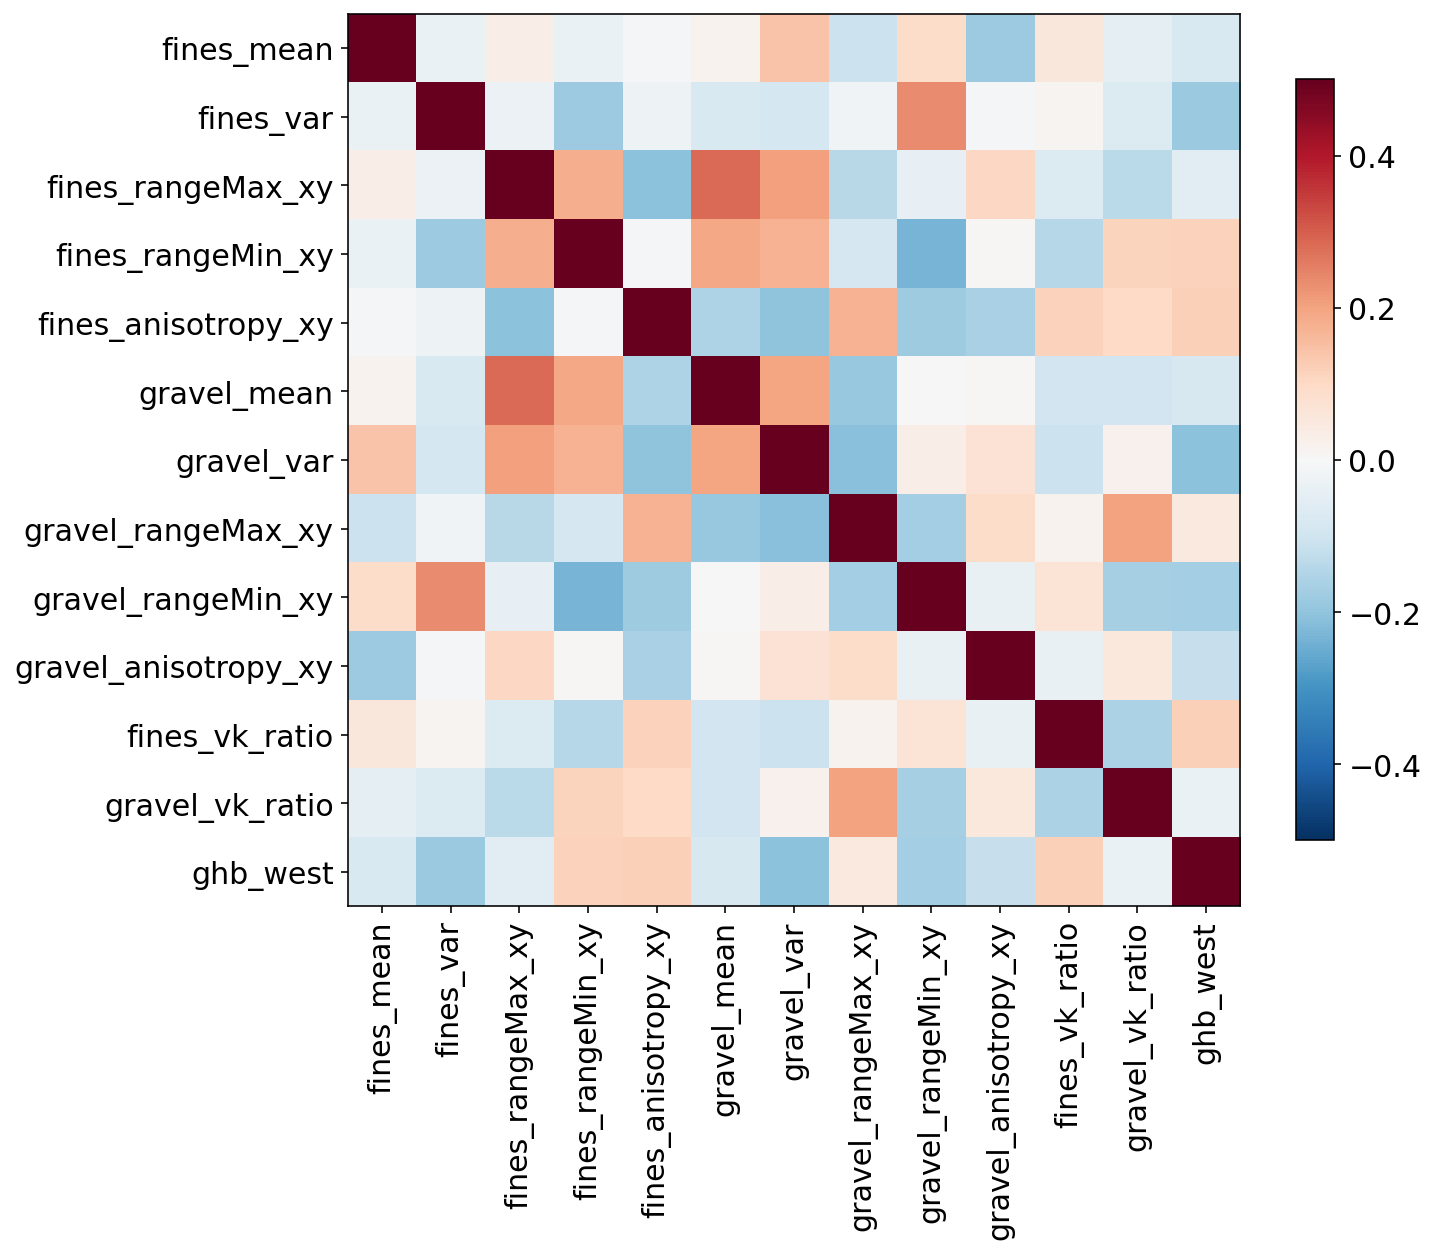

In [32]:
plt.figure(figsize = [10,10])
plt.imshow(np.corrcoef(theta_pos_MC[[0,1,2,3,11,4,5,6,7,12,8,9,10],:]),cmap = 'RdBu_r',vmin = -0.5,vmax = 0.5)
plt.colorbar(shrink = 0.7)
plt.xticks(np.arange(13),theta_name, rotation = 90)
plt.yticks(np.arange(13),theta_name)

# Hierarchical Bayes: inverse spatial variable

**The goal is to compare local spatial inversion and global spatial inversion**.

Random sample the posterior global varible $\theta ~ p(\theta|d_{obs})$ and solve the spatial inversion $p(m|\theta,d_{obs})$

In [33]:
real_idx = 0
theta_pos_real = theta_pos_MC[:,real_idx]

In [34]:
print_theta_multiple(theta_pos_real.reshape(1,-1),theta_name)

         fines_mean  fines_var  fines_rangeMax_xy  fines_rangeMin_xy  \
theta_1   -3.603399    0.84407          56.155287          55.396139   

         fines_anisotropy_xy  gravel_mean  gravel_var  gravel_rangeMax_xy  \
theta_1            79.500098    -1.922817    0.798395           80.867233   

         gravel_rangeMin_xy  gravel_anisotropy_xy  fines_vk_ratio  \
theta_1           49.087198              36.11945       -1.126545   

         gravel_vk_ratio  ghb_west  
theta_1        -1.854955  0.016006  


Sample 100 realizations of $m$ given fixed $\theta$

In [ ]:
# takes about 1 mins
num_pos_sample = 100
loghk_posterior = generate_m_MC_same_theta(theta_pos_real,num_sample = num_pos_sample)
loghk_posterior = np.swapaxes(loghk_posterior,1,3)

## Inverse with direct data

In [55]:
global_PCA_result = PCA_fast(loghk_posterior.reshape(-1,400000).T)

In [74]:
m_pc_cut_off = num_pos_sample-1
m_pos_global = ensemble_smoother(global_PCA_result['pc_scores'][:m_pc_cut_off,:],
                                 loghk_posterior[:,:,direct_k_wells[0],direct_k_wells[1]][:,[1,5],:].reshape(num_pos_sample,-1).T,
                                 np.log10(d_obs[-4:]).reshape(-1,1))

In [75]:
m_pos_reconstruct_global = reconstruction(global_PCA_result,
                                          pc_scores=np.vstack([m_pos_global,
                                                               global_PCA_result['pc_scores'][m_pc_cut_off:,:]]),
                                          n_component=num_pos_sample)

In [77]:
m_pos_reconstruct_global = m_pos_reconstruct_global.T.reshape(-1,200,200,10)

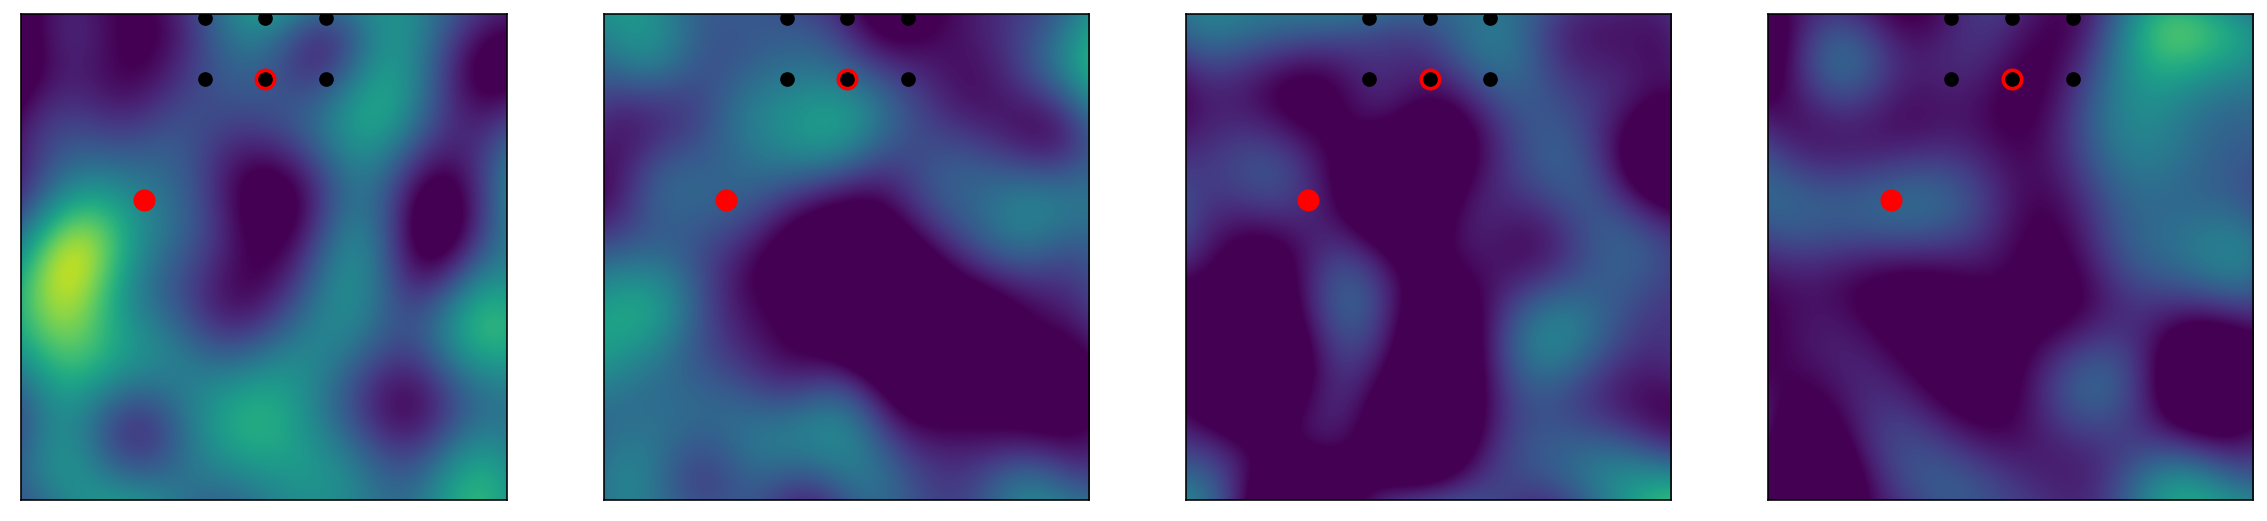

In [111]:
visualize_multiple_m(m_pos_reconstruct_global[:,:,:,2])

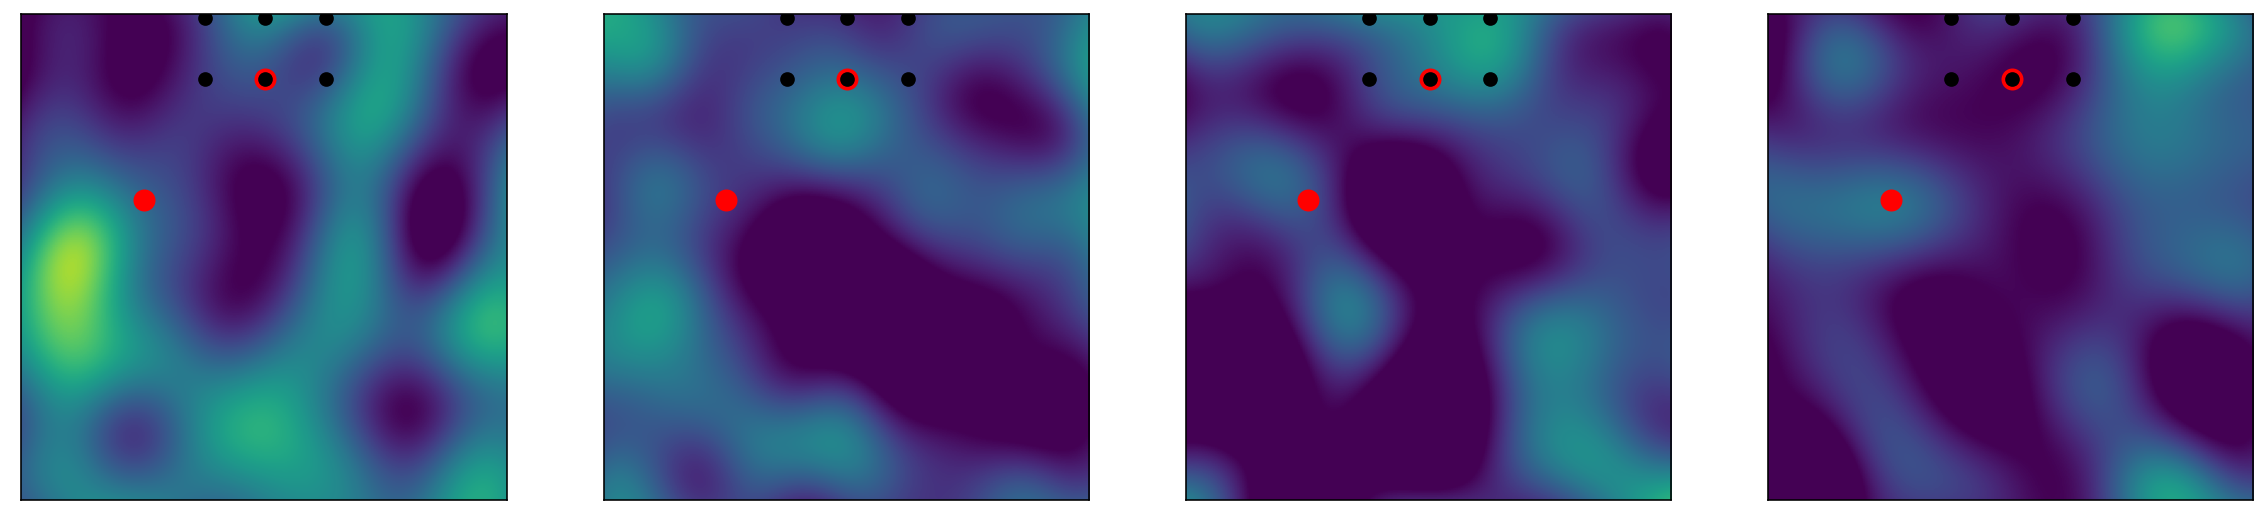

In [112]:
visualize_multiple_m(np.swapaxes(loghk_posterior,1,3)[:,:,:,2])

In [ ]:
visualize_mean_var_MC(np.swapaxes(loghk_posterior,1,3)[:,:,:,5],start_loc = 10, num_grid = 10,vmin = -2.5, vmax = -0.3)

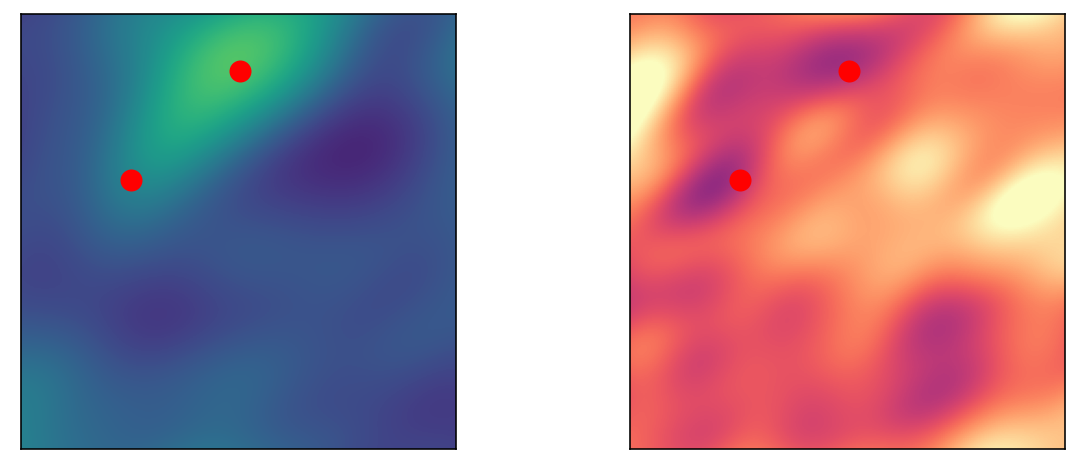

In [145]:
visualize_mean_var_MC(m_pos_reconstruct_global[:,:,:,5],start_loc = 10, num_grid = 10,vmin = -2.5, vmax = -0.3)

Run non-linear forward modeling, modflow simulation: 

In [155]:
loghk_posterior = m_pos_reconstruct_global.reshape(num_pos_sample,-1)
loghk_posterior = loghk_posterior.reshape(num_pos_sample,200,200,10)

In [173]:
modflowpath = path+'/utils/mfnwt'
data_pos = np.zeros((len(d_obs),num_pos_sample))
for i in tqdm(range(num_pos_sample)):
    log_hk = loghk_posterior[i,:,:,:]

    vka_ratio = np.zeros((1,nlay))
    vka_ratio[:,:4] = theta_pos_real[-3].reshape(-1,1)
    vka_ratio[:,4:] = theta_pos_real[-2].reshape(-1,1)

    log_vka = log_hk+np.expand_dims(vka_ratio, axis=(0, 1))
    log_vka = log_vka[0,:,:,:]

    stageleft =  theta_pos_real[-1]
    
    indirect_head, direct_k = run_modflow(fname, nrow, ncol, nlay, log_hk, log_vka, stageleft, path = modflowpath)
    data_pos[:-4,i] = indirect_head.reshape(-1)
    data_pos[-4:,i] = direct_k.reshape(-1)

100%|██████████| 100/100 [49:22<00:00, 29.63s/it]


## Sensitivity analysis

Head data after conditioning on the direct data

In [188]:
success_index_modflow_pos = np.unique(np.where(~np.isnan(data_pos))[1])

In [270]:
global_PCA_result = PCA_fast(loghk_posterior.reshape(num_pos_sample,-1)[success_index_modflow_pos,:].T)

Text(0, 0.5, 'head (m)')

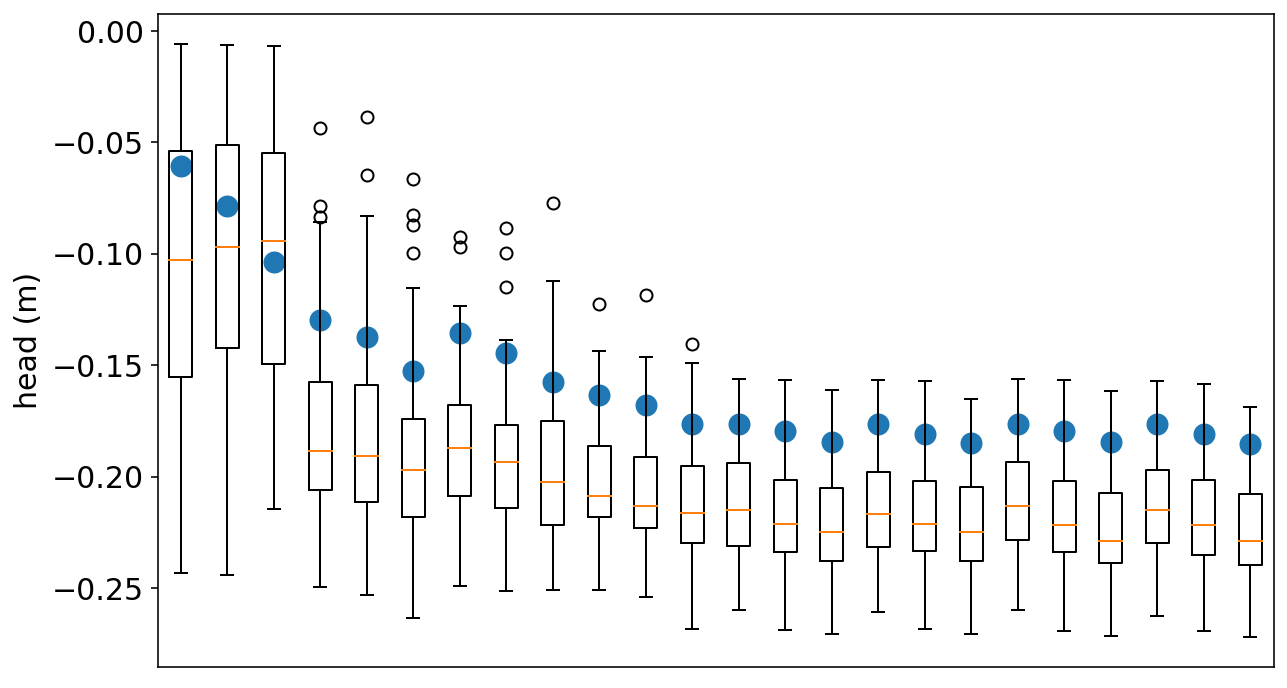

In [215]:
plt.figure(figsize=[10,6])
plt.scatter(np.arange(1,25),d_obs[:-4],s = 100)
plt.boxplot(data_pos[:-4,success_index_modflow_pos].T)
plt.xticks([])
plt.ylabel('head (m)')

### Sensitivity analysis: the global principal components

In [272]:
# pos data_PCA
pca = PCA(n_components=24)
pca.fit(data_pos[:-4,success_index_modflow_pos].T)
d_pos_pcs = pca.transform(data_pos[:-4,success_index_modflow_pos].T)
d_obs_pos_pcs = pca.transform(d_obs[:24].reshape(1,-1)).T

In [361]:
# Sensitivity analysis: global PC
num_PC_sensitive = 10
globalPC_name = ['PC_'+str(i) for i in np.arange(1,num_PC_sensitive+1)]
dgsa_d_global_m = DGSA_light(global_PCA_result['pc_scores'][:num_PC_sensitive,:].T, 
                             data_pos[:-4,success_index_modflow_pos].T, 
                             globalPC_name,n_clsters=4,n_boots = 3000)
dgsa_d_global_m['name'] = globalPC_name
dgsa_d_global_m['sensitive'] = (dgsa_d_global_m[0]>1)*1

100%|██████████| 3000/3000 [00:02<00:00, 1072.37it/s]


(0.0, 1.5)

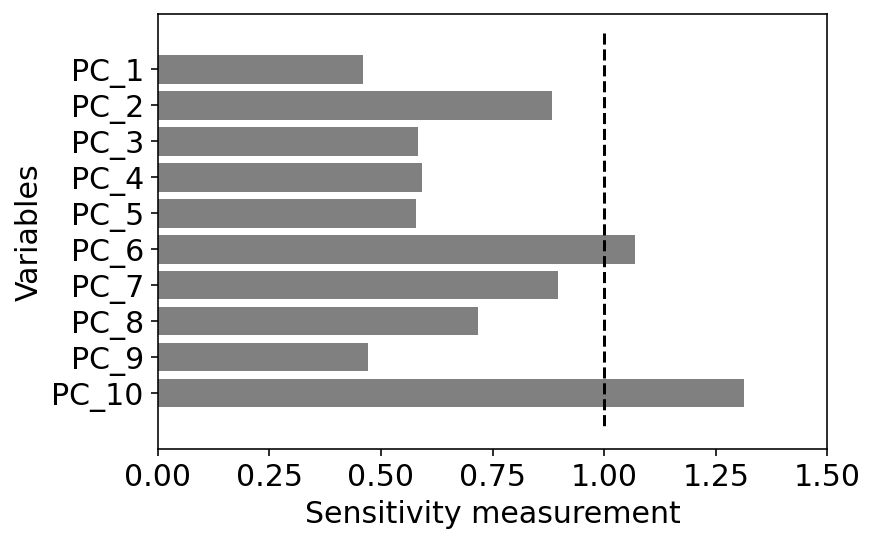

In [362]:
plt.rcParams.update({'font.size': 15})
sns.barplot(x = 0,y = 'name', data=dgsa_d_global_m,color = 'grey')
plt.vlines(x = 1, ymin = -1, ymax = len(globalPC_name),color = 'black',linestyle = '--')
plt.xlabel('Sensitivity measurement')
plt.ylabel('Variables')
plt.xlim(0,1.5)
#plt.title('Sensitivity analysis: observed drawdown curves')

### Sensitivity analysis: the local principal components

In [389]:
num_PC_sensitive = 10

local_boundary = 45
local_indicator = np.zeros((nrow,ncol,nlay))
local_indicator[:] = np.nan
local_indicator[(100-local_boundary):(100+local_boundary),
                0:(local_boundary),:] = 1

In [391]:
global_PCA_result,local_PCA_result,_,_ = local_PCA(loghk_posterior.reshape(num_pos_sample,-1)[success_index_modflow_pos,:].T, 
                                                   local_indicator, project = True)

In [399]:
# Sensitivity analysis: local PC
localPC_name = ['local_PC_'+str(i) for i in np.arange(1,num_PC_sensitive+1)]
dgsa_d_local_m = DGSA_light(local_PCA_result['pc_scores'][:num_PC_sensitive,:].T,  data_pos[:-4,success_index_modflow_pos].T, 
                            localPC_name,n_clsters=4,n_boots = 3000)
dgsa_d_local_m['name'] = localPC_name
dgsa_d_local_m['sensitive'] = (dgsa_d_local_m[0]>1)*1

100%|██████████| 3000/3000 [00:03<00:00, 931.90it/s]


(0.0, 1.5)

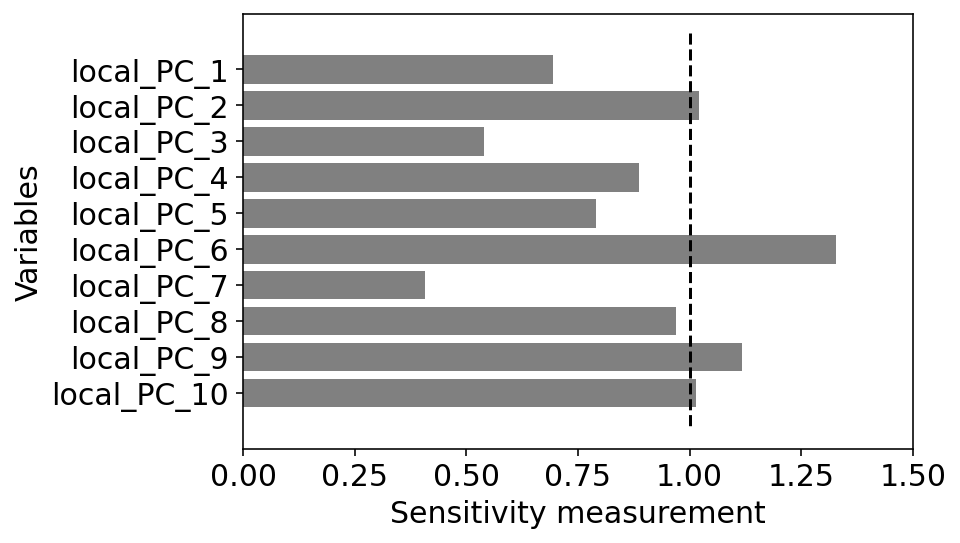

In [400]:
sns.barplot(x = 0,y = 'name', data=dgsa_d_local_m,color = 'grey')
plt.vlines(x = 1, ymin = -1, ymax = len(localPC_name),color = 'black',linestyle = '--')
plt.xlabel('Sensitivity measurement')
plt.ylabel('Variables')
plt.xlim(0,1.5)

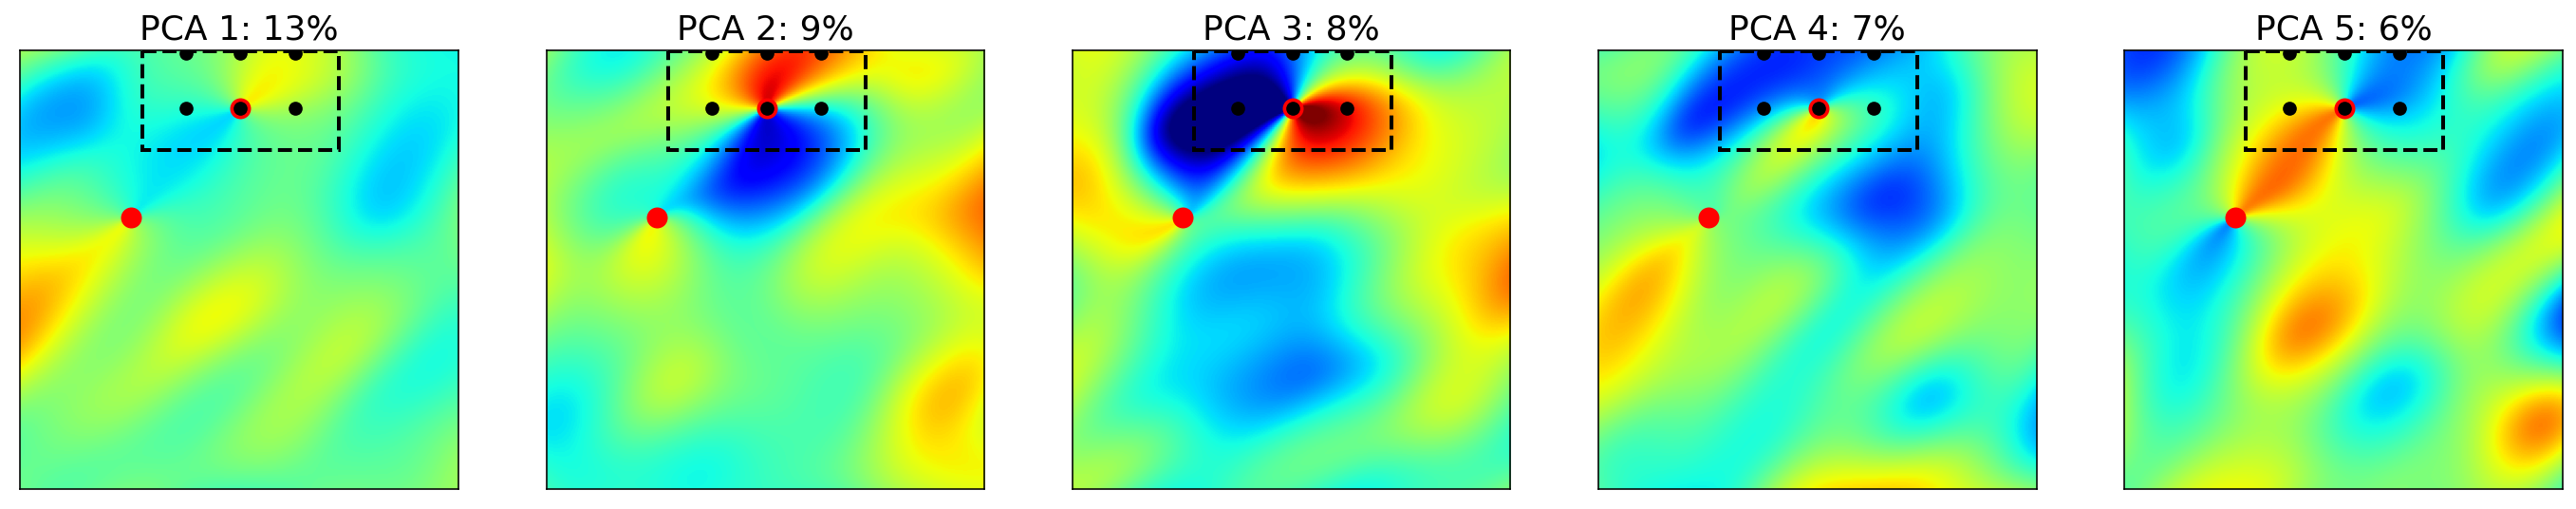

In [530]:
visualize_multiple_pc(local_PCA_result['eigen_vectors_all'].T.reshape(-1,200,200,10)[:,:,:,5],local_PCA_result,
                      head = 5,
                      vmin = -0.01, vmax = 0.01,cmap = 'jet',rect = True)

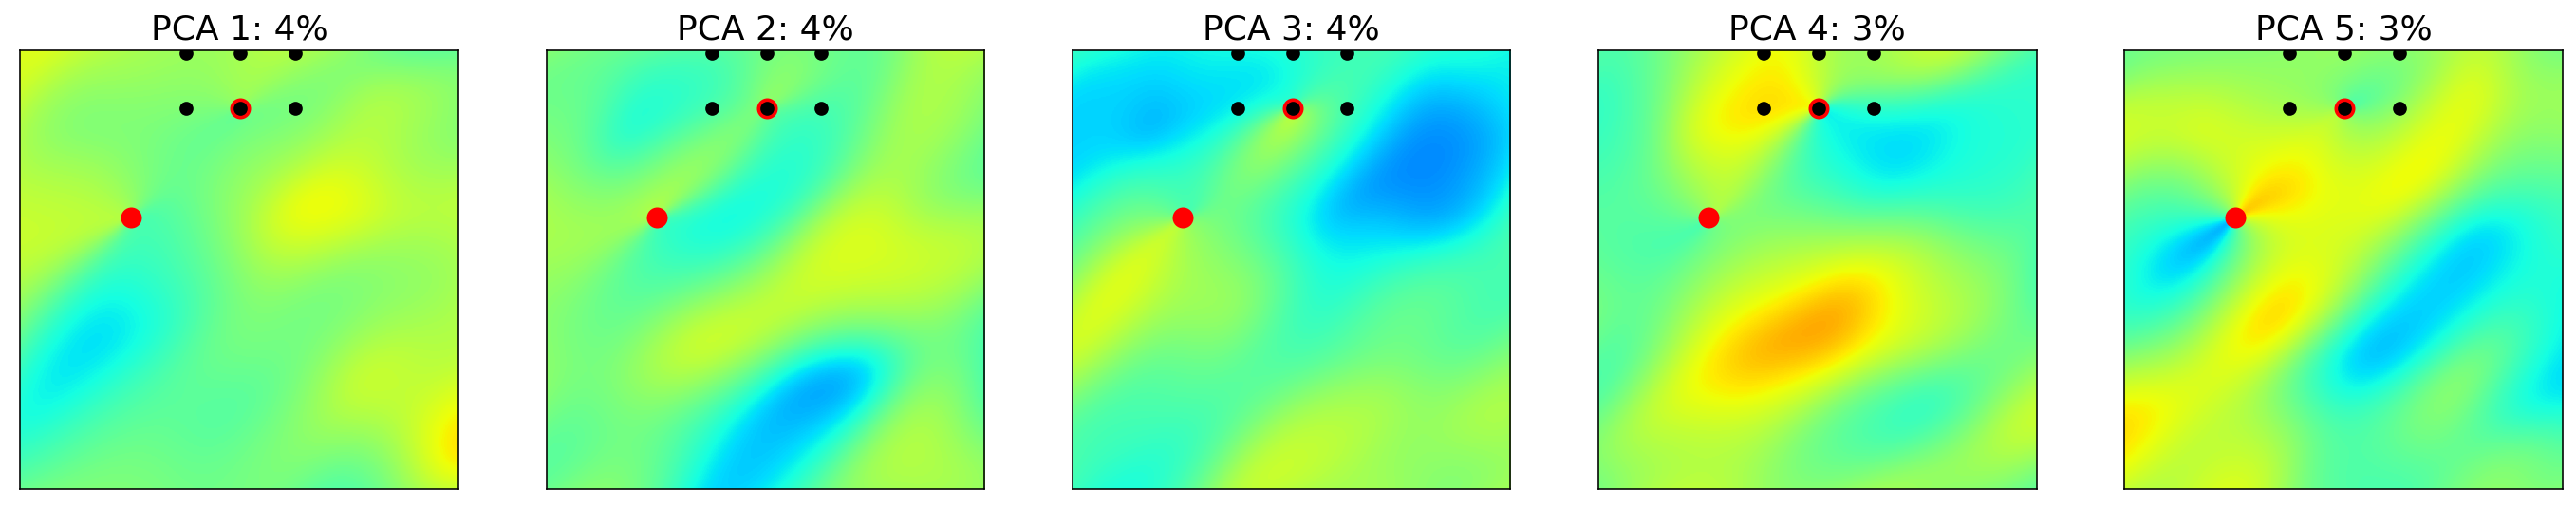

In [529]:
visualize_multiple_pc(global_PCA_result['eigen_vectors'].T.reshape(-1,200,200,10)[:,:,:,5], 
                      global_PCA_result,head = 5,
                      vmin = -0.01, vmax = 0.01,cmap = 'jet')

### Find the local area size

In [387]:
# find the local area size
num_PC_sensitive = 10
i = 0
for local_boundary in np.arange(5,100,5):
    local_indicator = np.zeros((nrow,ncol,nlay))
    local_indicator[:] = np.nan
    local_indicator[(100-local_boundary):(100+local_boundary),
                    0:(local_boundary),:] = 1
    
    global_PCA_result,local_PCA_result,_,_ = local_PCA(loghk_posterior.reshape(num_pos_sample,-1)[success_index_modflow_pos,:].T, 
                                                       local_indicator, project = True)

    # Sensitivity analysis: local PC
    localPC_name = ['local_PC_'+str(i) for i in np.arange(1,num_PC_sensitive+1)]
    dgsa_d_local_m = DGSA_light(local_PCA_result['pc_scores'][:num_PC_sensitive,:].T,  data_pos[:-4,success_index_modflow_pos].T, 
                                localPC_name,n_clsters=4,n_boots = 3000)
    
    dgsa_local[i,:] = dgsa_d_local_m[0]
    i = i+1

100%|██████████| 3000/3000 [00:03<00:00, 884.66it/s]


Text(0.5, 1.0, '# of sensitive principal components')

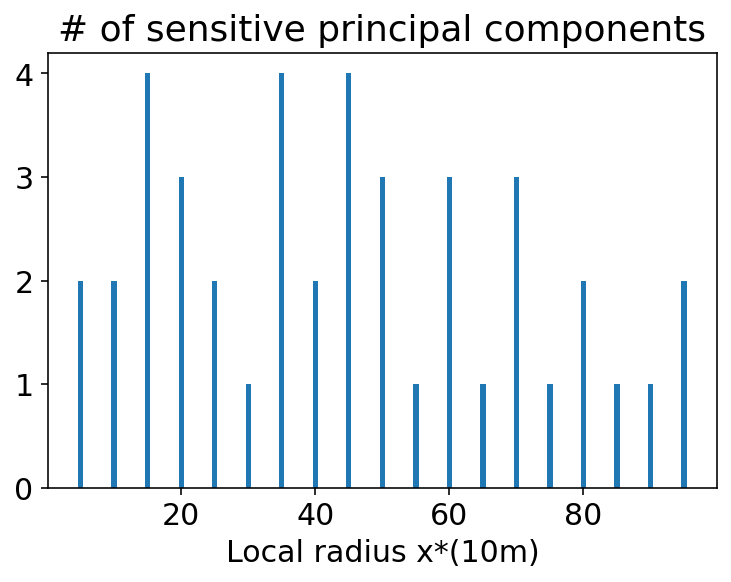

In [388]:
plt.bar(np.arange(5,100,5),np.sum(dgsa_local[:,:]>1,axis = 1))
plt.xlabel('Local radius x*(10m)')
plt.title('# of sensitive principal components')

# Ensemble smoother: non-linear inversion

In [402]:
# rerun with the reasonable local size 
local_boundary = 45
local_indicator = np.zeros((nrow,ncol,nlay))
local_indicator[:] = np.nan
local_indicator[(100-local_boundary):(100+local_boundary),
                0:(local_boundary),:] = 1

global_PCA_result,local_PCA_result,_,_ = local_PCA(loghk_posterior.reshape(num_pos_sample,-1)[success_index_modflow_pos,:].T, 
                                                   local_indicator, project = True)

## Inverse the global PCs

In [404]:
# inverse first 30 components
m_pos_global = ensemble_smoother(global_PCA_result['pc_scores'][:30,:],
                                 d_pos_pcs[:,:10].T,d_obs_pos_pcs[:10,:1])
m_pos_reconstruct_global = reconstruction(global_PCA_result,
                                          pc_scores=np.vstack([m_pos_global,
                                                               global_PCA_result['pc_scores'][30:,:]]),
                                          n_component=num_pos_sample)

In [405]:
m_pos_reconstruct_global = m_pos_reconstruct_global.T.reshape(-1,200,200,10)

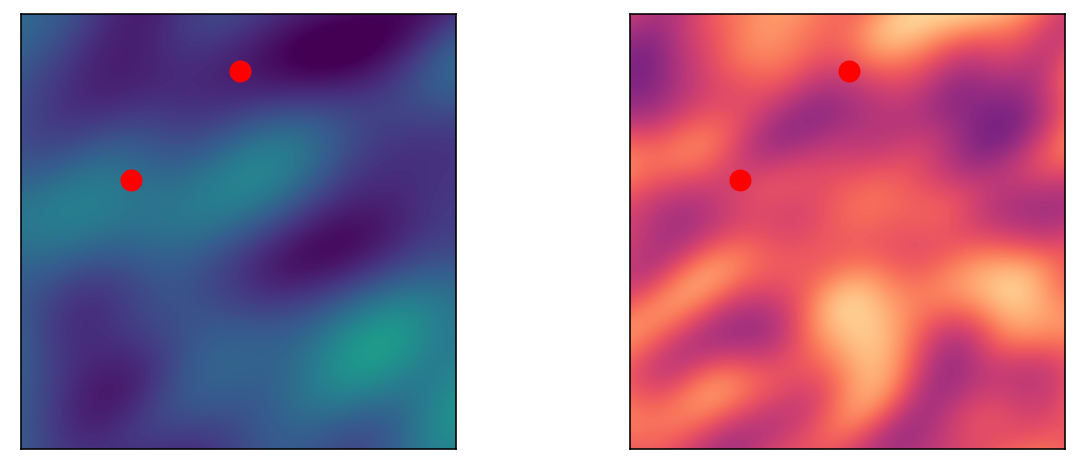

In [430]:
visualize_mean_var_MC(m_pos_reconstruct_global[:,:,:,8],start_loc = 10, num_grid = 10,vmin = -2.5, vmax = -0.3)

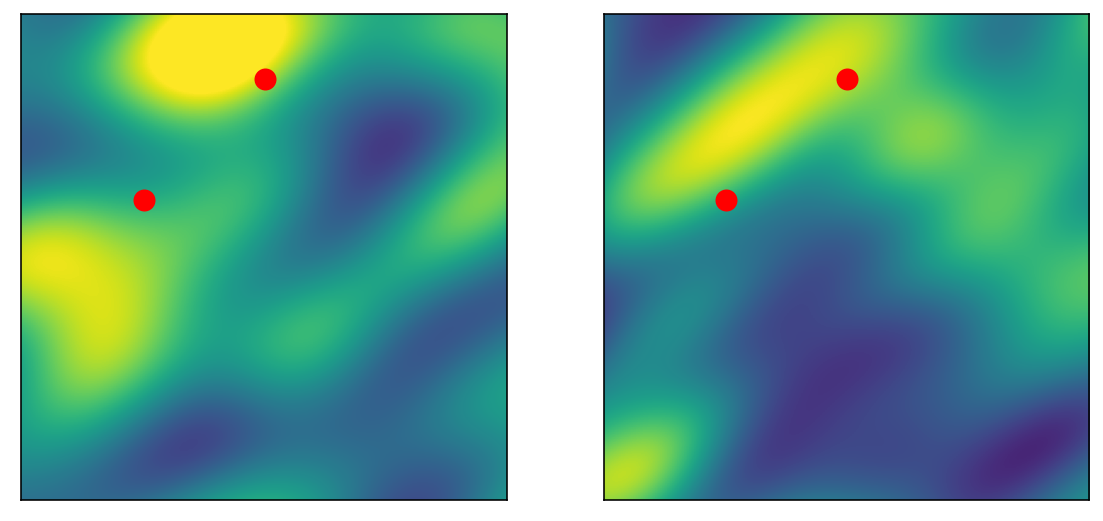

In [586]:
visualize_multiple_m(loghk_posterior[:,:,:,5],vmin = -4, vmax = -0,head = 2)

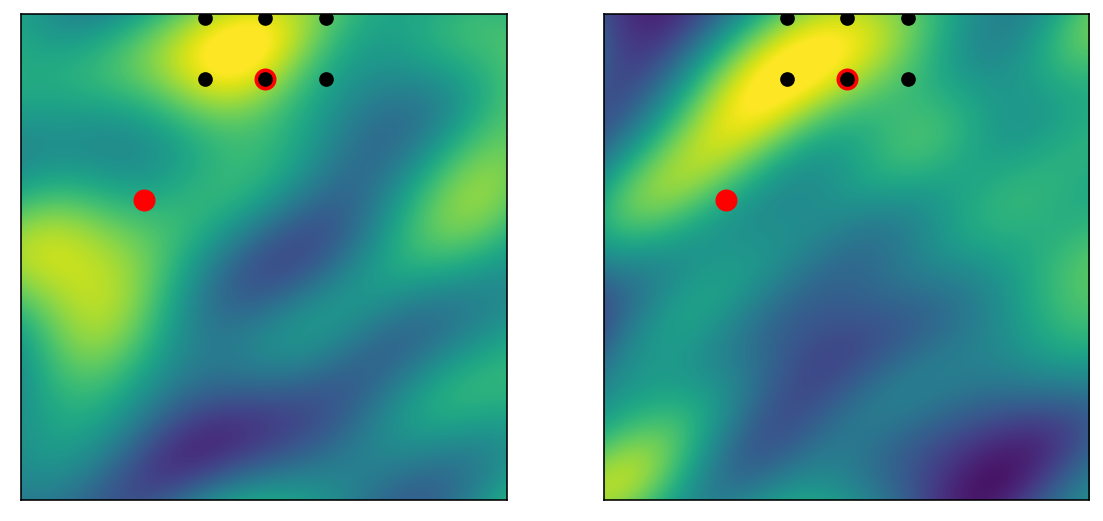

In [578]:
visualize_multiple_m(m_pos_reconstruct_global[:,:,:,5],vmin = -4, vmax = -0,head = 2)

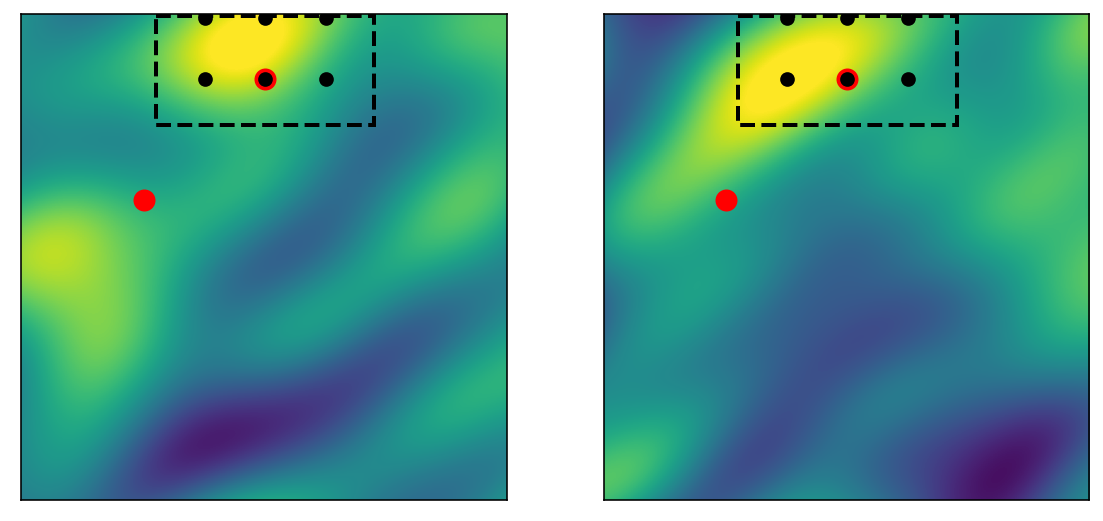

In [582]:
visualize_multiple_m(m_pos_reconstruct_local[:,:,:,5],vmin = -4, vmax = -0,head = 2,rect = True)

## Inverse the local PCs

In [408]:
# inverse first 30 components
m_pos_local = ensemble_smoother(local_PCA_result['pc_scores'][:30,:],
                                 d_pos_pcs[:,:10].T,d_obs_pos_pcs[:10,:1])
m_pos_reconstruct_local = reconstruction_localPCA(global_PCA_result,
                                                  local_PCA_result,
                                                  pc_scores=np.vstack([m_pos_local,local_PCA_result['pc_scores'][30:,:]]),
                                                  n_component=num_pos_sample-1)

In [410]:
m_pos_reconstruct_local = m_pos_reconstruct_local.T.reshape(-1,200,200,10)

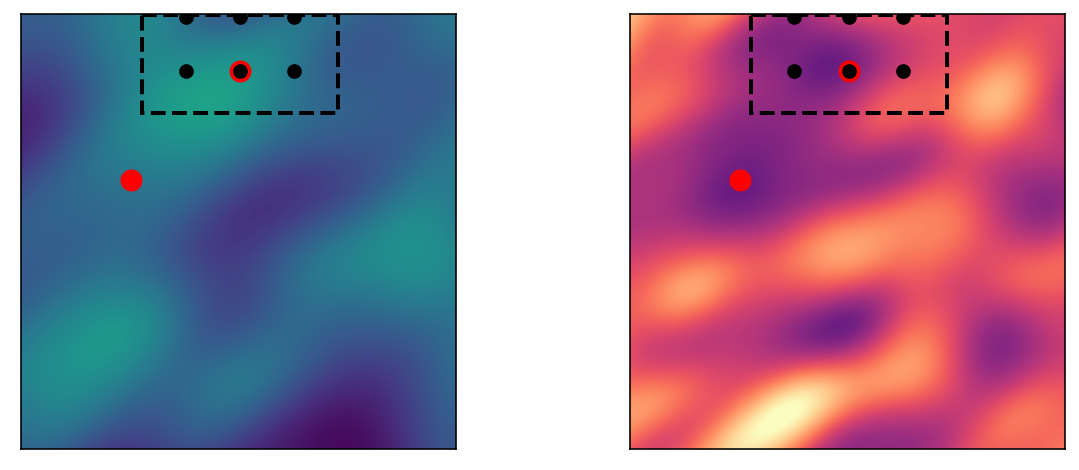

In [568]:
visualize_mean_var_MC(m_pos_reconstruct_local[:,:,:,4],vmin = -2.5, vmax = -0.3,rect = True)

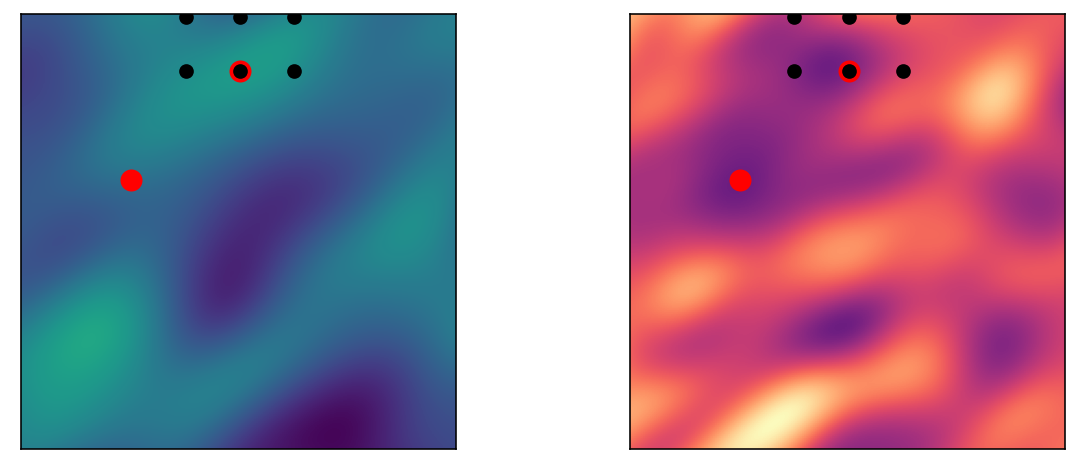

In [569]:
visualize_mean_var_MC(m_pos_reconstruct_global[:,:,:,4],vmin = -2.5, vmax = -0.3)

Difference between inversion with global and local PCs

In [537]:
diff_var = -np.var(m_pos_reconstruct_global,axis = 0)+np.var(m_pos_reconstruct_local,axis = 0)

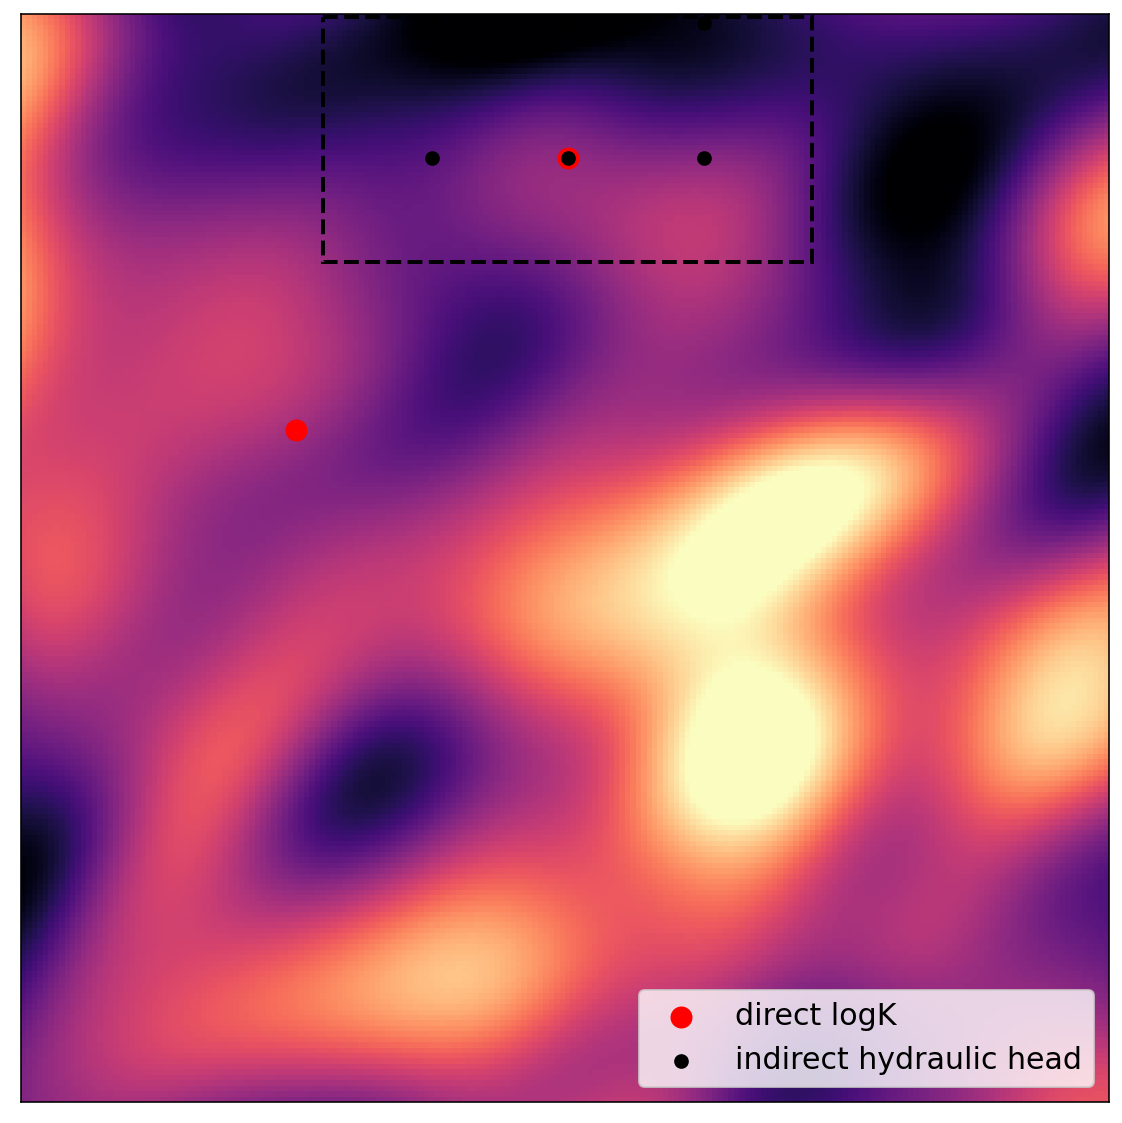

In [571]:
plt.figure(figsize=[10,10])
ax = plt.subplot(1, 1, 1)
ax.imshow(diff_var[:,:,4].T,cmap = 'magma',vmin = -0.05,vmax = 0.05)
#ax.colorbar(shrink = 0.4)

ax.scatter(direct_k_wells[1],direct_k_wells[0],color = 'red',s = 100,label = 'direct logK')
ax.scatter(head_wells[1],head_wells[0],color = 'k',s = 40,label = 'indirect hydraulic head')
ax.set_xticks([])
ax.set_yticks([])
rect = patches.Rectangle((55,0),90, 45, linewidth=2,linestyle = 'dashed', edgecolor='black',facecolor='None')
ax.add_patch(rect)
plt.legend(loc = 'lower right')

## Posterior drawdown curves

In [433]:
N = len(success_index_modflow_pos)
d_pos_global = np.zeros((28,N))

# forward modeling
for i in tqdm(range(N)):
    log_hk = m_pos_reconstruct_global[i,:,:,:]

    vka_ratio = np.zeros((1,nlay))
    vka_ratio[:,:4] = theta_pos_real[-3].reshape(-1,1)
    vka_ratio[:,4:] = theta_pos_real[-2].reshape(-1,1)

    log_vka = log_hk+np.expand_dims(vka_ratio, axis=(0, 1))
    log_vka = log_vka[0,:,:,:]

    stageleft =  theta_pos_real[-1]
    
    indirect_head, direct_k = run_modflow(fname, nrow, ncol, nlay, log_hk, log_vka, stageleft, path = modflowpath)
    d_pos_global[:-4,i] = indirect_head.reshape(-1)
    d_pos_global[-4:,i] = direct_k.reshape(-1)

100%|██████████| 62/62 [25:29<00:00, 24.68s/it]


In [440]:
N = len(success_index_modflow_pos)
d_pos_local = np.zeros((28,N))

# forward modeling
for i in tqdm(range(N)):
    log_hk = m_pos_reconstruct_local[i,:,:,:]

    vka_ratio = np.zeros((1,nlay))
    vka_ratio[:,:4] = theta_pos_real[-3].reshape(-1,1)
    vka_ratio[:,4:] = theta_pos_real[-2].reshape(-1,1)

    log_vka = log_hk+np.expand_dims(vka_ratio, axis=(0, 1))
    log_vka = log_vka[0,:,:,:]

    stageleft =  theta_pos_real[-1]
    
    indirect_head, direct_k = run_modflow(fname, nrow, ncol, nlay, log_hk, log_vka, stageleft, path = modflowpath)
    d_pos_local[:-4,i] = indirect_head.reshape(-1)
    d_pos_local[-4:,i] = direct_k.reshape(-1)

array([-0.04648047, -0.04738943,         nan,         nan,         nan,
               nan, -0.08969152, -0.08602513, -0.06675162, -0.09059827,
       -0.06957388, -0.0560473 , -0.09096422, -0.07127424,         nan,
       -0.05107769, -0.0683421 , -0.03624856, -0.05832089,         nan,
       -0.07549899, -0.04315875, -0.05553361, -0.04282655, -0.10837565,
       -0.03149087, -0.06283224, -0.060993  , -0.07396169, -0.06343161,
       -0.08250622, -0.03479213, -0.04939687,         nan, -0.08814602,
       -0.05673283, -0.0279426 ,         nan, -0.04806066, -0.07135238,
       -0.06551378, -0.02808266, -0.07327871, -0.08768614, -0.05092415,
       -0.08824445, -0.04703376, -0.08410064, -0.06492961, -0.05078848,
       -0.06986954, -0.04886559, -0.10551507, -0.06406265, -0.05616185,
       -0.07281246, -0.07708948,         nan, -0.04710166,         nan,
               nan, -0.04692451])

In [445]:
idx_global = np.unique(np.where(~np.isnan(d_pos_global))[1])
idx_local = np.unique(np.where(~np.isnan(d_pos_local))[1])

Text(0.5, 1.0, 'ES update with full-domain PCA')

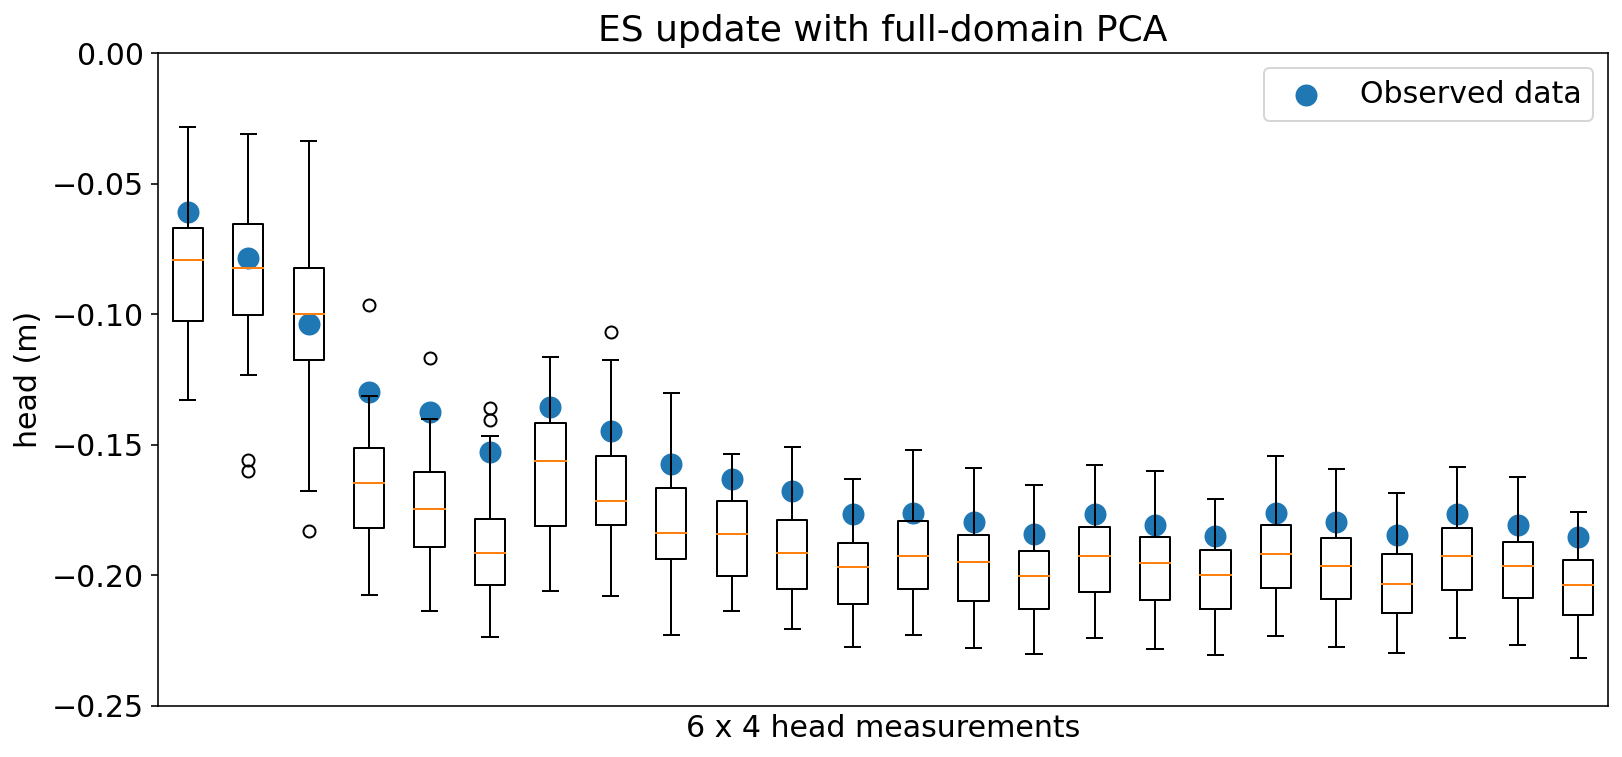

In [486]:
plt.figure(figsize=[13,6])
plt.scatter(np.arange(1,25),d_obs[:-4],s = 100,label = 'Observed data')
plt.boxplot(d_pos_global[:-4,idx_global].T)
plt.xlabel('6 x 4 head measurements')
plt.xticks([])
plt.legend()
plt.ylabel('head (m)')
plt.ylim(-0.25,0.)
plt.title('ES update with full-domain PCA')

Text(0.5, 1.0, 'ES update with local PCA')

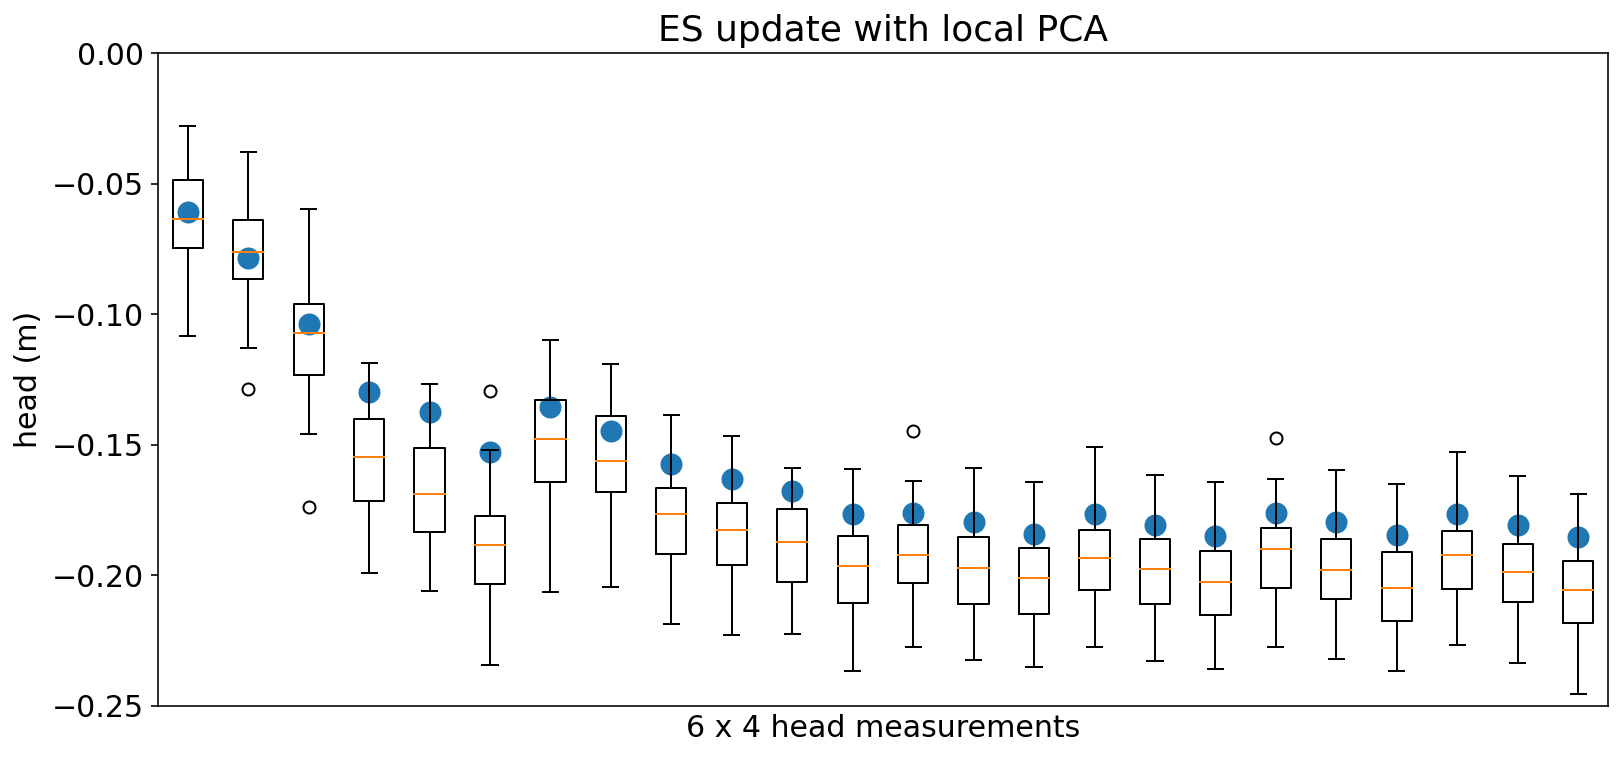

In [485]:
plt.figure(figsize=[13,6])
plt.scatter(np.arange(1,25),d_obs[:-4],s = 100)
plt.boxplot(d_pos_local[:-4,idx_local].T)
plt.xticks([])
plt.ylabel('head (m)')
plt.xlabel('6 x 4 head measurements')
plt.ylim(-0.25,0.)
plt.title('ES update with local PCA')

Text(0.5, 1.0, 'Variance comparison')

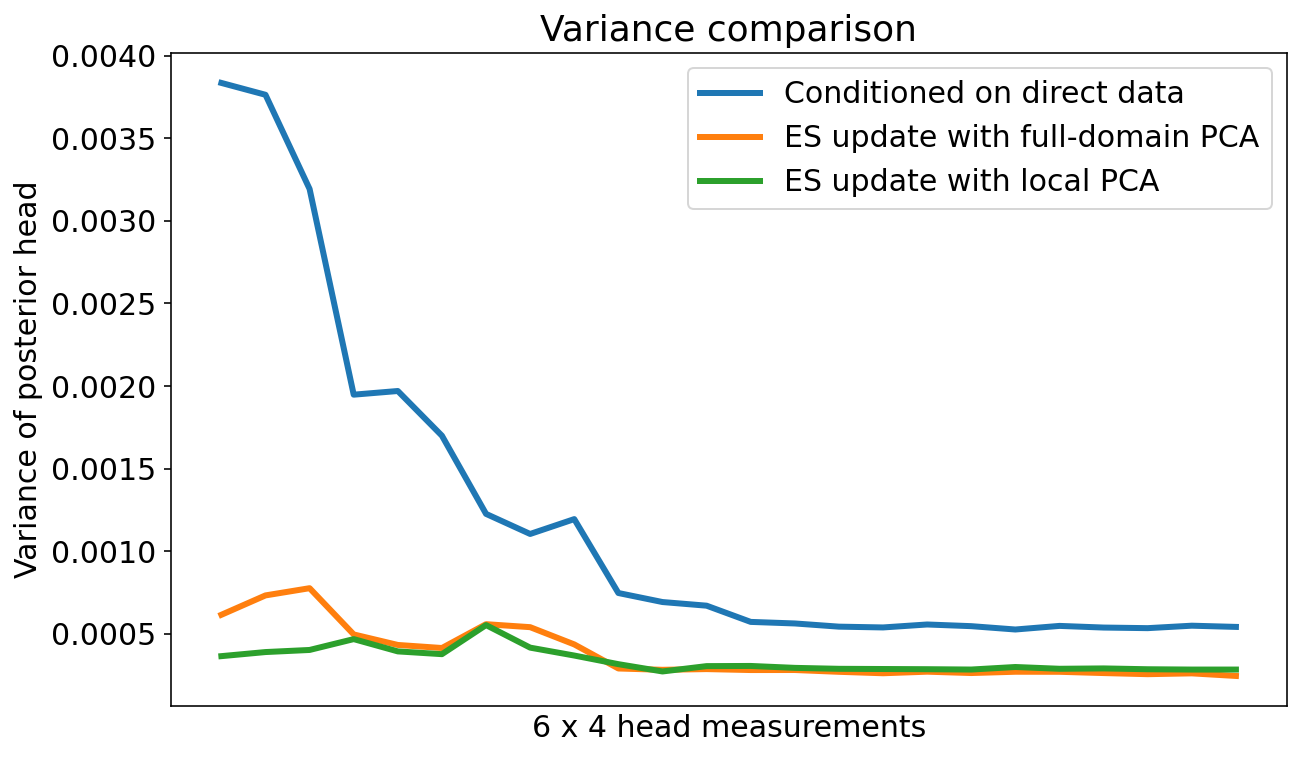

In [491]:
plt.figure(figsize=[10,6])
plt.plot(np.var(data_pos[:-4,success_index_modflow_pos],axis = 1),linewidth = 3, label = 'Conditioned on direct data')
plt.plot(np.var(d_pos_global[:-4,idx_global],axis = 1),linewidth = 3,label = 'ES update with full-domain PCA')
plt.plot(np.var(d_pos_local[:-4,idx_local],axis = 1),linewidth = 3,label = 'ES update with local PCA')
plt.legend()

plt.xticks([])
plt.ylabel('Variance of posterior head')
plt.xlabel('6 x 4 head measurements')
plt.title('Variance comparison')

# ES-MDA: many ES iterations for non-linear inversion

In [626]:
def ES_multiple_iteration(loghk_posterior, theta_current, local_indicator, iter_times = 4):
    num_pos_sample = 100
    d_pos_list = []
    loghk_list = []
    loghk_list.append(loghk_posterior)
    
    for num_iter in range(iter_times):
        num_iter_inloop = loghk_posterior.shape[0]
        d_pos = np.zeros((28,num_iter_inloop))

        # forward modeling
        for i in tqdm(range(num_iter_inloop)):
            stageleft = theta_current[-1]
            log_hk = loghk_posterior[i,:,:,:]
            
            vka_ratio = np.zeros((1,nlay))
            vka_ratio[:,:4] = theta_current[-3].reshape(-1,1)
            vka_ratio[:,4:] = theta_current[-2].reshape(-1,1)

            log_vka = log_hk+np.expand_dims(vka_ratio, axis=(0, 1))
            log_vka = log_vka[0,:,:,:]

            indirect_head, direct_k = run_modflow(fname, nrow, ncol, nlay, log_hk, 
                                                  log_vka, stageleft, path = modflowpath)
            d_pos[:-4,i] = indirect_head.reshape(-1)
            d_pos[-4:,i] = direct_k.reshape(-1)
 
        d_pos_list.append(d_pos)
        
        idx = np.unique(np.where(~np.isnan(d_pos))[1])
        # PCA on d
        dim = np.int(np.min([24,len(idx)]))
        pca = PCA(n_components=dim) #np.int(np.min([24,len(idx)]))
        pca.fit(d_pos[:-4,idx].T)
        d_pos_pcs = pca.transform(d_pos[:-4,idx].T)
        d_obs_pos_pcs = pca.transform(d_obs[:24].reshape(1,-1)).T
        
        # PCA on m
        global_PCA_result,local_PCA_result,_,_ = local_PCA(loghk_posterior.reshape(num_iter_inloop,-1)[idx,:].T, 
                                                           local_indicator, project = True)

        m_pos_local = ensemble_smoother(local_PCA_result['pc_scores'][:30,:],
                                        d_pos_pcs[:,:10].T,d_obs_pos_pcs[:10,:])
        m_pos_reconstruct_local = reconstruction_localPCA(global_PCA_result,
                                                          local_PCA_result,
                                                          pc_scores=np.vstack([m_pos_local,local_PCA_result['pc_scores'][30:,:]]),
                                                          n_component=dim-1)
        loghk_posterior = m_pos_reconstruct_local.T.reshape(len(idx),200,200,10)
        loghk_list.append(loghk_posterior)
        
    # posterior data after multiple inversions
    num_iter_inloop = loghk_posterior.shape[0]
    d_pos = np.zeros((28,num_iter_inloop))
    
    # forward modeling
    for i in tqdm(range(num_iter_inloop)):
        stageleft = theta_current[-1]
        log_hk = loghk_posterior[i,:,:,:]

        vka_ratio = np.zeros((1,nlay))
        vka_ratio[:,:4] = theta_current[-3].reshape(-1,1)
        vka_ratio[:,4:] = theta_current[-2].reshape(-1,1)

        log_vka = log_hk+np.expand_dims(vka_ratio, axis=(0, 1))
        log_vka = log_vka[0,:,:,:]

        indirect_head, direct_k = run_modflow(fname, nrow, ncol, nlay, log_hk, 
                                              log_vka, stageleft, path = modflowpath)
        d_pos[:-4,i] = indirect_head.reshape(-1)
        d_pos[-4:,i] = direct_k.reshape(-1)
        
        
    d_pos_list.append(d_pos)
    
    return loghk_list,d_pos_list

# Posterior of spatial variables

Sample different posterior global variables and perform local inversions

In [ ]:
# We can paralleize this process later to make it faster
num_sample = 30
loghk_pos_final = np.zeros((num_sample,200,200,10))
d_pos_final = np.zeros((28,num_sample))

for i in np.arange(num_sample): # sample 30 different posterior global variables
    num_pos_sample = 100
    theta_pos_real = theta_pos_MC[:,i]
    loghk_posterior = generate_m_MC_same_theta(theta_pos_real,num_sample = num_pos_sample)
    
    global_PCA_result = PCA_fast(loghk_posterior.reshape(-1,400000).T)
    m_pc_cut_off = num_pos_sample-1
    m_pos_global = ensemble_smoother(global_PCA_result['pc_scores'][:m_pc_cut_off,:],
                                     np.swapaxes(loghk_posterior,1,3)[:,:,direct_k_wells[0],direct_k_wells[1]][:,[1,5],:].reshape(num_pos_sample,-1).T,
                                     np.log10(d_obs[-4:]).reshape(-1,1))

    m_pos_reconstruct_global = reconstruction(global_PCA_result,
                                              pc_scores=np.vstack([m_pos_global,
                                                                   global_PCA_result['pc_scores'][m_pc_cut_off:,:]]),
                                              n_component=num_pos_sample)

    m_pos_reconstruct_global = m_pos_reconstruct_global.T.reshape(-1,200,200,10)
    
    
    loghk_list_local_,d_pos_local_ = ES_multiple_iteration(m_pos_reconstruct_global, 
                                                           theta_pos_real, local_indicator, 
                                                           iter_times = 2)
    loghk_pos_final[i,:,:,:] = loghk_list_local_[-1][0,:,:,:]
    d_pos_final[:,i] = d_pos_local_[-1][:,0]

Text(0.5, 1.0, 'Posterior head measurements')

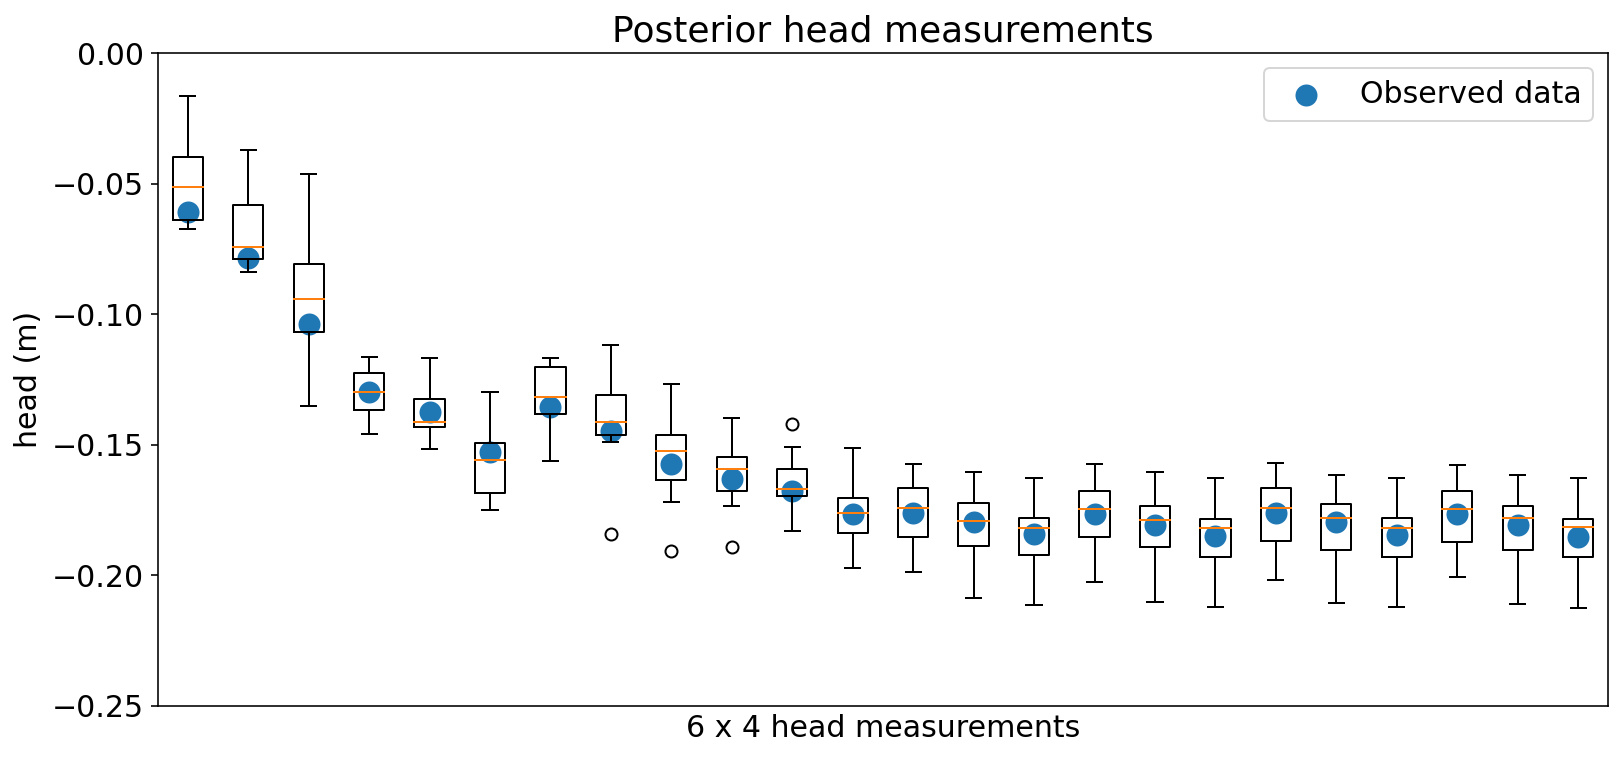

In [657]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=[13,6])
plt.scatter(np.arange(1,25),d_obs[:-4],s = 100,label = 'Observed data')
plt.boxplot(d_pos_final[:-4,idx[:13]].T)
plt.xlabel('6 x 4 head measurements')
plt.xticks([])
plt.legend()
plt.ylabel('head (m)')
plt.ylim(-0.25,0.)
plt.title('Posterior head measurements')

Text(0.5, 1.0, 'Prior head measurements')

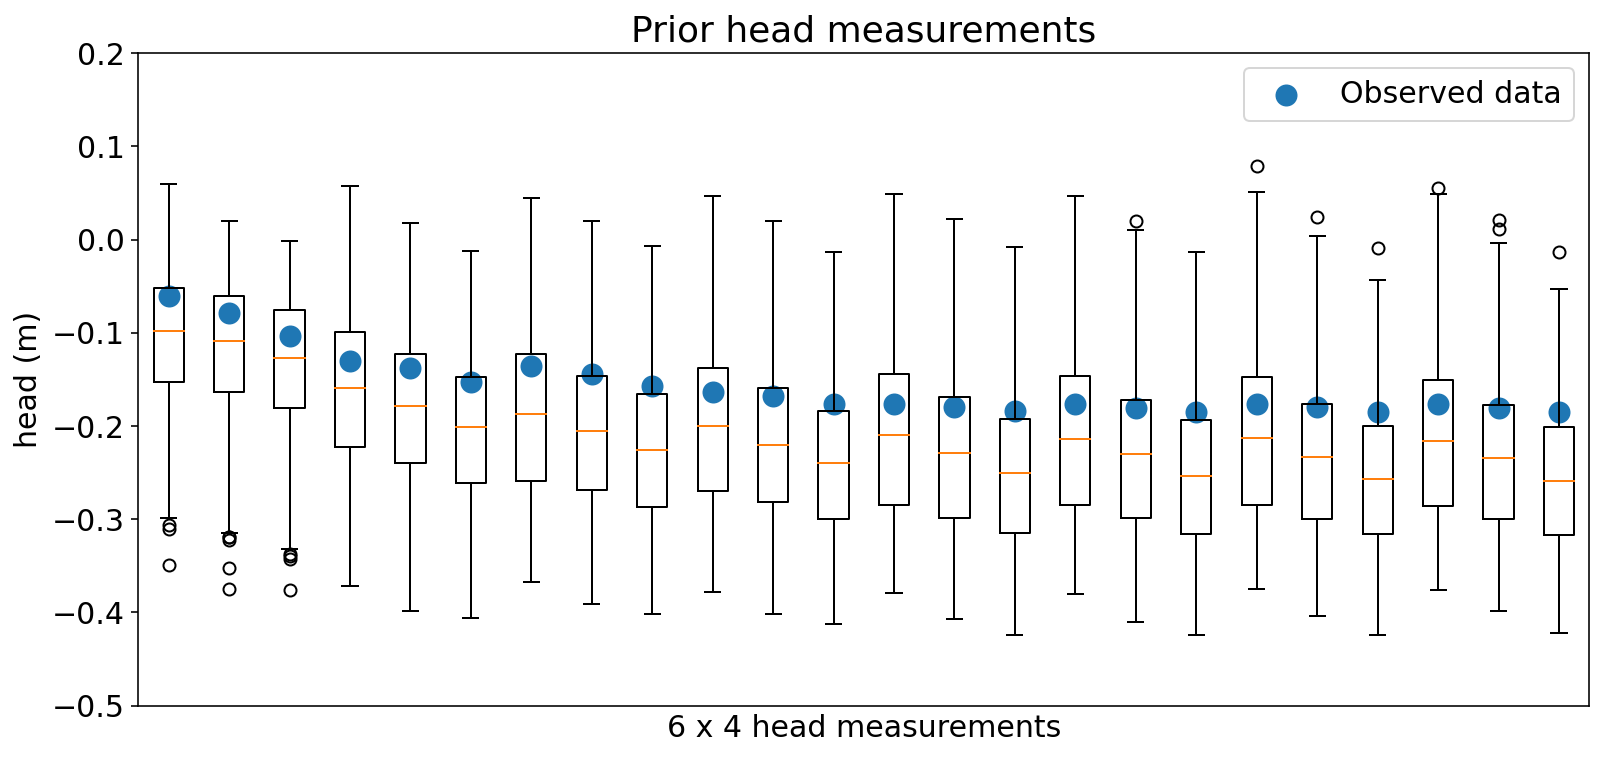

In [659]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=[13,6])
plt.scatter(np.arange(1,25),d_obs[:-4],s = 100,label = 'Observed data')
plt.boxplot(d[:-4,:].T)
plt.xlabel('6 x 4 head measurements')
plt.xticks([])
plt.legend()
plt.ylabel('head (m)')
plt.ylim(-0.5,0.2)
plt.title('Prior head measurements')

In [662]:
pos_mean = np.mean(loghk_pos_final,axis = 0)

In [665]:
pos_var = np.var(loghk_pos_final,axis = 0)

ERROR:root:Attempt to use a texture buffer exceeding your hardware's limits. This can happen when trying to color by cell data with a large dataset. Hardware limit is 65536 values while 80000 was requested.


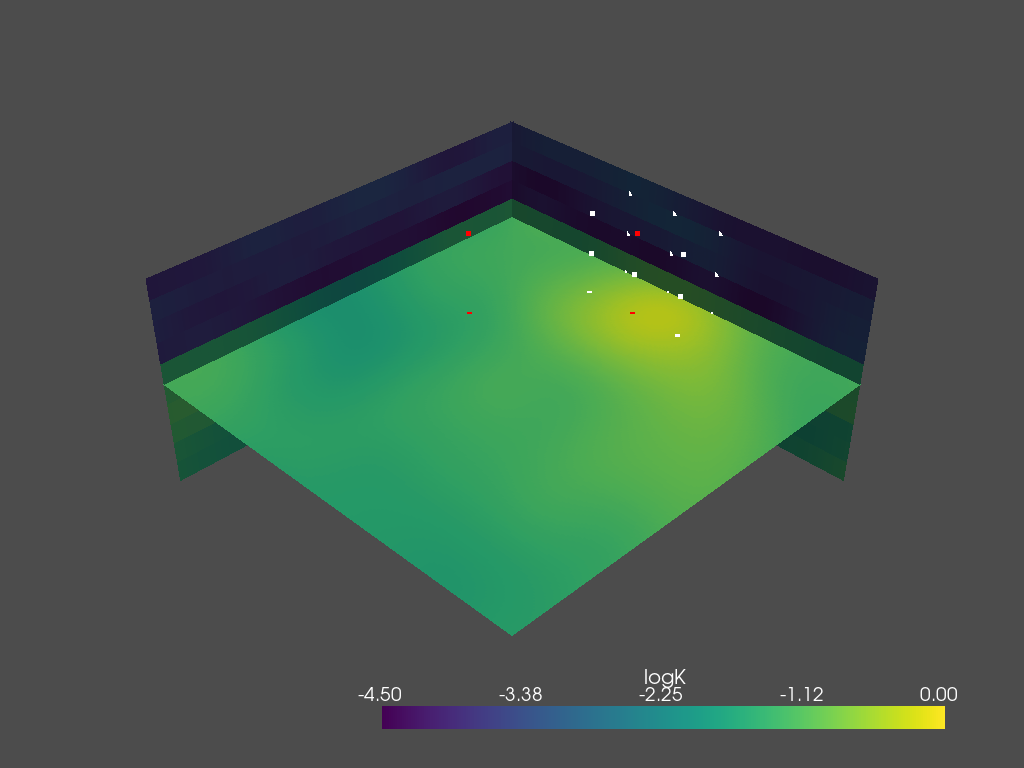

In [677]:
grid = uniform_grid(pos_mean)
p = pv.Plotter()
slices = grid.slice_orthogonal(x=20, y=20, z=1000)
p.add_mesh(slices, cmap='viridis',clim=[-4.5, 0])
p.add_point_labels(poly,"My Labels", point_size=5, font_size=36, shape = 'rounded_rect')
p.add_point_labels(poly2,"My Labels", point_size=5, font_size=36,point_color = 'red',shape = 'rounded_rect')
p.show(jupyter_backend='static')

ERROR:root:Attempt to use a texture buffer exceeding your hardware's limits. This can happen when trying to color by cell data with a large dataset. Hardware limit is 65536 values while 80000 was requested.


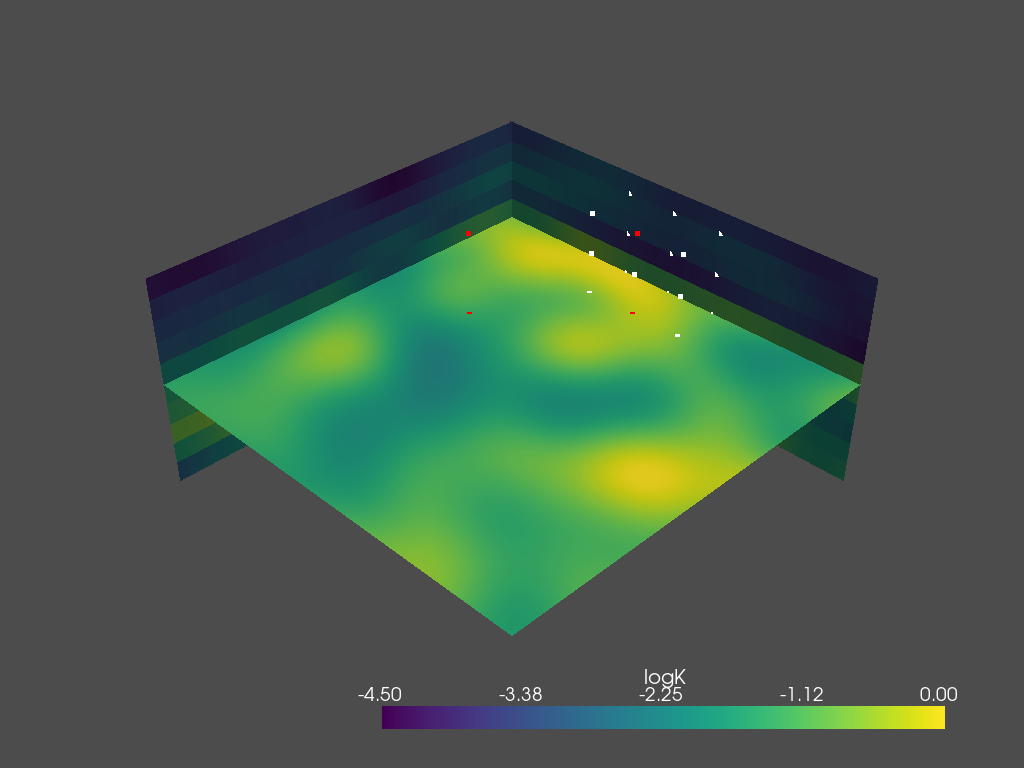

In [678]:
grid = uniform_grid(m_true[0,:,:,:])
p = pv.Plotter()
slices = grid.slice_orthogonal(x=20, y=20, z=1000)
p.add_mesh(slices, cmap='viridis',clim=[-4.5, 0])
p.add_point_labels(poly,"My Labels", point_size=5, font_size=36, shape = 'rounded_rect')
p.add_point_labels(poly2,"My Labels", point_size=5, font_size=36,point_color = 'red',shape = 'rounded_rect')
p.show(jupyter_backend='static')

ERROR:root:Attempt to use a texture buffer exceeding your hardware's limits. This can happen when trying to color by cell data with a large dataset. Hardware limit is 65536 values while 80000 was requested.


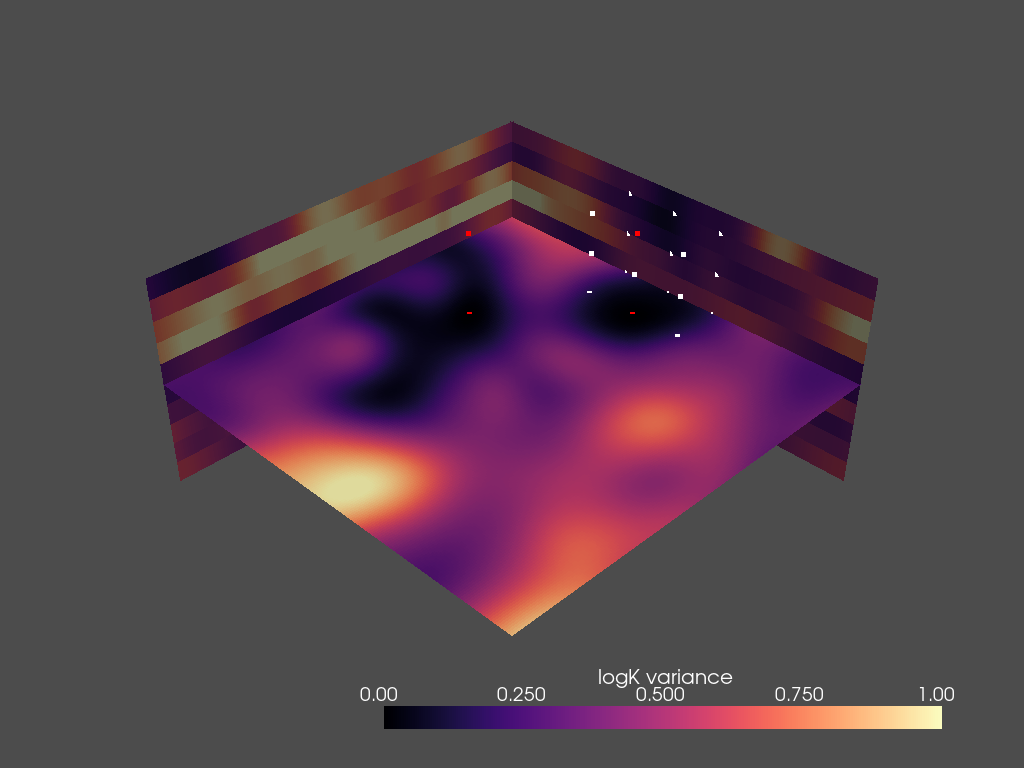

In [679]:
grid = uniform_grid(pos_var,name = 'logK variance')
p = pv.Plotter()
slices = grid.slice_orthogonal(x=20, y=20, z=1000)
p.add_mesh(slices, cmap='magma',clim=[0, 1])
p.add_point_labels(poly,"My Labels", point_size=5, font_size=36, shape = 'rounded_rect')
p.add_point_labels(poly2,"My Labels", point_size=5, font_size=36,point_color = 'red',shape = 'rounded_rect')
p.show(jupyter_backend='static')